In [1]:
import pandas as pd
import openml
import data_preprocess as dp

data_name = 'abalone'

data = openml.datasets.get_dataset(720)

X, y, categorical_indicator, attribute_names = data.get_data(
    target=data.default_target_attribute, dataset_format="dataframe"
)

c:\users\amr20\appdata\local\programs\python\python38\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(


# Data Preprocessing

In [2]:
nominal = [b for a, b in zip(categorical_indicator, attribute_names) if a]
encoded_data = pd.get_dummies(X, columns=nominal)

columns = encoded_data.columns
updates = {}
for col in columns:
    if any(x in col for x in set((',', '[', ']', '<', '>'))):
        updates[col] = col.replace(',', '_').replace('[', '_').replace(']', '_').replace('<', 'less').replace('>', 'greater')
encoded_data = encoded_data.rename(columns=updates)

encoded_data.fillna(0, inplace=True)
encoded_data

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Sex_M,Sex_F,Sex_I
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,1,0,0
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,1,0,0
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,0,1,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,1,0,0
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,0,0,1
...,...,...,...,...,...,...,...,...,...,...
4172,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,0,1,0
4173,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,1,0,0
4174,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,1,0,0
4175,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,0,1,0


In [3]:
mapping = {'P': 1, 'N': 0}

y = y.replace(mapping)

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

train_data, left_out, train_label, y_left_out = train_test_split(encoded_data, y, test_size=0.4, random_state=42)
test_data, dev_data, test_label, dev_label = train_test_split(left_out, y_left_out, test_size=0.5, random_state=42)

print(f'train shape: {train_data.shape}\n test shape: {test_data.shape}\n dev shape: {dev_data.shape}')

train shape: (2506, 10)
 test shape: (835, 10)
 dev shape: (836, 10)


In [5]:
normalized_train_data = dp.min_max_normalize(train_data, train_data)

normalized_test_data = dp.min_max_normalize(test_data, train_data)

normalized_dev_data = dp.min_max_normalize(dev_data, train_data)

# Build graph

In [6]:
adj_matrix, index_to_name, name_to_index = dp.compute_adjacency_matrix(data=normalized_train_data, 
                                                                       self_loop_weight=20, threshold=0.2)
        

In [7]:
#oversampled_data, oversampled_labels = dp.oversample(normalized_train_data, train_label, oversampled_class=1, num_folds=2)

train = dp.transform_to_tensors(normalized_train_data, train_label, adj_matrix)

test = dp.transform_to_tensors(normalized_test_data, test_label, adj_matrix)

dev = dp.transform_to_tensors(normalized_dev_data, dev_label, adj_matrix)


In [8]:
from torch.utils.data import DataLoader
import torch

batch_size = 64

train_dataset = dp.Data(data=train)
val_dataset = dp.Data(data=dev)
test_dataset = dp.Data(data=test)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

# Train IGNNet

In [9]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score

In [10]:
import torch.nn as nn
from ignnet import train_model

gnn_model = train_model(input_dim=1,
            adj_matrix=adj_matrix, 
            index_to_name=index_to_name,
            train_dataloader=train_dataloader,
            val_dataloader=val_dataloader,
            data_name=data_name,
            num_classes=1,
            num_epochs=400,
            learning_rate=1e-03,
            normalize_adj=False)


100%|█████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 105.60it/s]
c:\users\amr20\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 18%|██████████████▌                                                                    | 7/40 [00:00<00:00, 62.42it/s]

Acc at dev is : 0.495
roc is : 0.500,  prec 0.24760765550239233,  recall 0.5, f-score 0.3312
Acc at epoch : 1 is : 0.5067837238311768, loss : 27.44320285320282


 18%|██████████████▌                                                                    | 7/40 [00:00<00:00, 62.32it/s]

Acc at dev is : 0.574
roc is : 0.578,  prec 0.7361842105263158,  recall 0.5780845754058199, f-score 0.49095188248736
Acc at epoch : 2 is : 0.5079808235168457, loss : 26.62310165166855


 18%|██████████████▌                                                                    | 7/40 [00:00<00:00, 62.92it/s]

Acc at dev is : 0.719
roc is : 0.721,  prec 0.7719652303769291,  recall 0.7209915974082468, f-score 0.7057074420994447
Acc at epoch : 3 is : 0.6045491099357605, loss : 26.011557281017303


 18%|██████████████▌                                                                    | 7/40 [00:00<00:00, 62.20it/s]

Acc at dev is : 0.633
roc is : 0.6361185520983584,  prec 0.7641071488066813,  recall 0.6361185520983584, f-score 0.5837132842519468
Acc at epoch : 4 is : 0.7090981602668762, loss : 25.281525433063507


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 53.43it/s]

Acc at dev is : 0.751
roc is : 0.752,  prec 0.7579764165318705,  recall 0.7519518281933283, f-score 0.7499079528718704
Acc at epoch : 5 is : 0.7362330555915833, loss : 24.303517997264862


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 55.47it/s]

Acc at dev is : 0.739
roc is : 0.7407216612862605,  prec 0.765605658709107,  recall 0.7407216612862605, f-score 0.733368445692884
Acc at epoch : 6 is : 0.7298483848571777, loss : 23.58415776491165


 18%|██████████████▌                                                                    | 7/40 [00:00<00:00, 62.22it/s]

Acc at dev is : 0.745
roc is : 0.7466458319023742,  prec 0.7700021930511607,  recall 0.7466458319023742, f-score 0.7399461105391136
Acc at epoch : 7 is : 0.7314445376396179, loss : 22.92983502149582


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 58.47it/s]

Acc at dev is : 0.720
roc is : 0.7196579435400783,  prec 0.7216677063838637,  recall 0.7196579435400783, f-score 0.7193181818181819
Acc at epoch : 8 is : 0.7258579134941101, loss : 22.839043259620667


 18%|██████████████▌                                                                    | 7/40 [00:00<00:00, 62.64it/s]

Acc at dev is : 0.722
roc is : 0.72445451839641,  prec 0.7689132104454686,  recall 0.72445451839641, f-score 0.7110972085679388
Acc at epoch : 9 is : 0.7386273145675659, loss : 22.523858040571213


 18%|██████████████▌                                                                    | 7/40 [00:00<00:00, 62.97it/s]

Acc at dev is : 0.750
roc is : 0.7511562149415023,  prec 0.7660574934969653,  recall 0.7511562149415023, f-score 0.7467294610151753
Acc at epoch : 10 is : 0.7394253611564636, loss : 22.212561905384064


 18%|██████████████▌                                                                    | 7/40 [00:00<00:00, 63.49it/s]

Acc at dev is : 0.740
roc is : 0.7419522861002359,  prec 0.7682799895914649,  recall 0.7419522861002359, f-score 0.7342988164337174
Acc at epoch : 11 is : 0.7398244142532349, loss : 21.87148889899254


 18%|██████████████▌                                                                    | 7/40 [00:00<00:00, 64.72it/s]

Acc at dev is : 0.748
roc is : 0.7479394189161345,  prec 0.7489554297537286,  recall 0.7479394189161344, f-score 0.7474164730005857
Acc at epoch : 12 is : 0.7330406904220581, loss : 21.90743136405945


 18%|██████████████▌                                                                    | 7/40 [00:00<00:00, 61.25it/s]

Acc at dev is : 0.689
roc is : 0.6914623257091833,  prec 0.7594471332836932,  recall 0.6914623257091833, f-score 0.66804928557902
Acc at epoch : 13 is : 0.7386273145675659, loss : 21.71963134407997


 18%|██████████████▌                                                                    | 7/40 [00:00<00:00, 63.15it/s]

Acc at dev is : 0.715
roc is : 0.7147812349749296,  prec 0.7176313652708503,  recall 0.7147812349749296, f-score 0.7142052767052767
Acc at epoch : 14 is : 0.7374301552772522, loss : 21.81039771437645


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 57.98it/s]

Acc at dev is : 0.755
roc is : 0.755,  prec 0.7577336269019839,  recall 0.7552773771092337, f-score 0.7543034176454818
Acc at epoch : 15 is : 0.7378292083740234, loss : 21.532107710838318


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 57.58it/s]

Acc at dev is : 0.754
roc is : 0.7544817638574077,  prec 0.763157894736842,  recall 0.7544817638574077, f-score 0.7517471227252808
Acc at epoch : 16 is : 0.7426177263259888, loss : 21.444300651550293


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 52.75it/s]

Acc at dev is : 0.736
roc is : 0.7374190077157314,  prec 0.7741235171661766,  recall 0.7374190077157314, f-score 0.7269730085193478
Acc at epoch : 17 is : 0.7386273145675659, loss : 21.718207716941833


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 53.33it/s]

Acc at dev is : 0.696
roc is : 0.6985255397577672,  prec 0.7605703639150164,  recall 0.6985255397577672, f-score 0.6777275928219325
Acc at epoch : 18 is : 0.7374301552772522, loss : 21.350449979305267


 18%|██████████████▌                                                                    | 7/40 [00:00<00:00, 60.32it/s]

Acc at dev is : 0.675
roc is : 0.6772901069212629,  prec 0.754252035723667,  recall 0.6772901069212629, f-score 0.648988916674385
Acc at epoch : 19 is : 0.7406225204467773, loss : 21.249895930290222


 30%|████████████████████████▌                                                         | 12/40 [00:00<00:00, 59.25it/s]

Acc at dev is : 0.755
roc is : 0.755,  prec 0.7595643195765349,  recall 0.7554147491814913, f-score 0.7539393678346578
Acc at epoch : 20 is : 0.7390263676643372, loss : 21.089981079101562


 18%|██████████████▌                                                                    | 7/40 [00:00<00:00, 61.21it/s]

Acc at dev is : 0.751
roc is : 0.7519747235387046,  prec 0.7583935950413223,  recall 0.7519747235387046, f-score 0.7498201573407458
Acc at epoch : 21 is : 0.7402234673500061, loss : 21.053354889154434


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 58.96it/s]

Acc at dev is : 0.749
roc is : 0.749513473910754,  prec 0.7547392534068862,  recall 0.749513473910754, f-score 0.7476716109003103
Acc at epoch : 22 is : 0.7438148260116577, loss : 21.125603765249252


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 59.27it/s]

Acc at dev is : 0.706
roc is : 0.7048675504269982,  prec 0.7122390891840606,  recall 0.7048675504269981, f-score 0.7028830984206238
Acc at epoch : 23 is : 0.7438148260116577, loss : 21.261141419410706


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 57.26it/s]

Acc at dev is : 0.663
roc is : 0.6656478237974219,  prec 0.7675665680473374,  recall 0.6656478237974219, f-score 0.628374160597749
Acc at epoch : 24 is : 0.7398244142532349, loss : 21.022025257349014


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 58.76it/s]

Acc at dev is : 0.751
roc is : 0.7524097351008541,  prec 0.7690411694365131,  recall 0.7524097351008541, f-score 0.7475845410628019
Acc at epoch : 25 is : 0.7378292083740234, loss : 21.112655222415924


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 53.00it/s]

Acc at dev is : 0.746
roc is : 0.7477161892987156,  prec 0.7668516463189049,  recall 0.7477161892987156, f-score 0.7421074688023841
Acc at epoch : 26 is : 0.7422186732292175, loss : 21.064861863851547


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 58.81it/s]

Acc at dev is : 0.757
roc is : 0.758,  prec 0.7681743308575608,  recall 0.7581278476085812, f-score 0.7550994491801197
Acc at epoch : 27 is : 0.7374301552772522, loss : 21.048955142498016


 18%|██████████████▌                                                                    | 7/40 [00:00<00:00, 59.49it/s]

Acc at dev is : 0.743
roc is : 0.7433145591501248,  prec 0.745655704073554,  recall 0.7433145591501248, f-score 0.7423182185062369
Acc at epoch : 28 is : 0.7362330555915833, loss : 20.63877871632576


 12%|██████████▍                                                                        | 5/40 [00:00<00:00, 44.98it/s]

Acc at dev is : 0.752
roc is : 0.7531366623165511,  prec 0.758996808292583,  recall 0.7531366623165511, f-score 0.7511529086948081
Acc at epoch : 29 is : 0.7470071911811829, loss : 20.84455496072769


 30%|████████████████████████▌                                                         | 12/40 [00:00<00:00, 58.72it/s]

Acc at dev is : 0.744
roc is : 0.7442246491288321,  prec 0.7445606071027352,  recall 0.744224649128832, f-score 0.7439663857849422
Acc at epoch : 30 is : 0.7402234673500061, loss : 20.62896654009819


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 55.46it/s]

Acc at dev is : 0.739
roc is : 0.7409048240492707,  prec 0.773319998960958,  recall 0.7409048240492708, f-score 0.7317104767288486
Acc at epoch : 31 is : 0.7450119853019714, loss : 20.580524802207947


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 48.51it/s]

Acc at dev is : 0.752
roc is : 0.7534114064610665,  prec 0.764861954473393,  recall 0.7534114064610664, f-score 0.749927385127607
Acc at epoch : 32 is : 0.7406225204467773, loss : 20.637116104364395


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 55.04it/s]

Acc at dev is : 0.756
roc is : 0.7569659088307347,  prec 0.7677553260013836,  recall 0.7569659088307348, f-score 0.753725653288972
Acc at epoch : 33 is : 0.7418196201324463, loss : 20.460561096668243


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 52.29it/s]

Acc at dev is : 0.734
roc is : 0.7343796506170296,  prec 0.7344440627504867,  recall 0.7343796506170296, f-score 0.734395035720828
Acc at epoch : 34 is : 0.7394253611564636, loss : 20.485914438962936


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 54.87it/s]

Acc at dev is : 0.727
roc is : 0.7292625409254299,  prec 0.7759680308667494,  recall 0.7292625409254299, f-score 0.7157955006322017
Acc at epoch : 35 is : 0.74301677942276, loss : 20.554078459739685


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 50.13it/s]

Acc at dev is : 0.742
roc is : 0.743091329532706,  prec 0.7673625100725221,  recall 0.743091329532706, f-score 0.736004631497693
Acc at epoch : 36 is : 0.7466081380844116, loss : 20.565270990133286


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 53.56it/s]

Acc at dev is : 0.750
roc is : 0.750721203379353,  prec 0.7561534008175295,  recall 0.750721203379353, f-score 0.7488323819408407
Acc at epoch : 37 is : 0.7378292083740234, loss : 20.35614913702011


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 58.19it/s]

Acc at dev is : 0.667
roc is : 0.6702955789088078,  prec 0.7605071448585038,  recall 0.6702955789088079, f-score 0.6370507799079227
Acc at epoch : 38 is : 0.7434158325195312, loss : 20.447717934846878


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 56.04it/s]

Acc at dev is : 0.737
roc is : 0.7386267371843304,  prec 0.7760780885780886,  recall 0.7386267371843305, f-score 0.7280882796468341
Acc at epoch : 39 is : 0.7450119853019714, loss : 20.454295247793198


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 57.34it/s]

Acc at dev is : 0.734
roc is : 0.734173592508643,  prec 0.7350615922044494,  recall 0.734173592508643, f-score 0.7341073587814257
Acc at epoch : 40 is : 0.7366321086883545, loss : 20.982339948415756


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 55.96it/s]

Acc at dev is : 0.754
roc is : 0.7543672871305264,  prec 0.7608471074380165,  recall 0.7543672871305264, f-score 0.752225732750931
Acc at epoch : 41 is : 0.744213879108429, loss : 20.46752554178238


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 53.22it/s]

Acc at dev is : 0.736
roc is : 0.7372129496073448,  prec 0.7648131936945284,  recall 0.7372129496073448, f-score 0.7289914702927089
Acc at epoch : 42 is : 0.7498005032539368, loss : 20.34987524151802


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 54.14it/s]

Acc at dev is : 0.740
roc is : 0.7407388327952926,  prec 0.7415809395803536,  recall 0.7407388327952927, f-score 0.7402667315718264
Acc at epoch : 43 is : 0.7446129322052002, loss : 20.377989381551743


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 55.77it/s]

Acc at dev is : 0.744
roc is : 0.7442246491288321,  prec 0.7445606071027352,  recall 0.744224649128832, f-score 0.7439663857849422
Acc at epoch : 44 is : 0.7422186732292175, loss : 20.254030019044876


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 54.94it/s]

Acc at dev is : 0.745
roc is : 0.7467145179385031,  prec 0.7726605643870625,  recall 0.7467145179385031, f-score 0.7393889101103369
Acc at epoch : 45 is : 0.7509976029396057, loss : 20.375212967395782


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 53.32it/s]

Acc at dev is : 0.740
roc is : 0.7419980767909884,  prec 0.7701550808631366,  recall 0.7419980767909884, f-score 0.733896602052117
Acc at epoch : 46 is : 0.74301677942276, loss : 20.354360789060593


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 56.73it/s]

Acc at dev is : 0.751
roc is : 0.7518373514664469,  prec 0.7560881914695474,  recall 0.7518373514664469, f-score 0.7503029885295149
Acc at epoch : 47 is : 0.7410215735435486, loss : 20.275301039218903


 12%|██████████▍                                                                        | 5/40 [00:00<00:00, 45.33it/s]

Acc at dev is : 0.728
roc is : 0.7304015843579,  prec 0.774137637484251,  recall 0.7304015843579, f-score 0.7177385409183329
Acc at epoch : 48 is : 0.748603343963623, loss : 20.050112545490265


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 52.12it/s]

Acc at dev is : 0.743
roc is : 0.7441387915836711,  prec 0.7633632799234356,  recall 0.744138791583671, f-score 0.7383754357619556
Acc at epoch : 49 is : 0.7462090849876404, loss : 20.236382693052292


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 28.66it/s]

Acc at dev is : 0.743
roc is : 0.7426276987888362,  prec 0.7431077694235588,  recall 0.7426276987888363, f-score 0.7426281596925399
Acc at epoch : 50 is : 0.7466081380844116, loss : 20.12989068031311


 12%|██████████▍                                                                        | 5/40 [00:00<00:00, 47.47it/s]

Acc at dev is : 0.694
roc is : 0.6962245575474506,  prec 0.7641547233780244,  recall 0.6962245575474506, f-score 0.6735729799643703
Acc at epoch : 51 is : 0.7509976029396057, loss : 19.96364352107048


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 56.94it/s]

Acc at dev is : 0.721
roc is : 0.7206138242095381,  prec 0.72539370654316,  recall 0.7206138242095381, f-score 0.7195967587534242
Acc at epoch : 52 is : 0.7470071911811829, loss : 20.22158846259117


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 56.36it/s]

Acc at dev is : 0.762
roc is : 0.763,  prec 0.7692156552237843,  recall 0.7627298120292145, f-score 0.7606875966483259
Acc at epoch : 53 is : 0.7454110383987427, loss : 20.12749394774437


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 52.96it/s]

Acc at dev is : 0.742
roc is : 0.7416947134647526,  prec 0.7416947134647527,  recall 0.7416947134647527, f-score 0.7416267942583732
Acc at epoch : 54 is : 0.7541899681091309, loss : 19.84573143720627


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 54.81it/s]

Acc at dev is : 0.738
roc is : 0.7397886759621769,  prec 0.7757515320260921,  recall 0.7397886759621769, f-score 0.7296803275420907
Acc at epoch : 55 is : 0.7509976029396057, loss : 19.993729382753372


 10%|████████▎                                                                          | 4/40 [00:00<00:00, 37.62it/s]

Acc at dev is : 0.748
roc is : 0.7488552327311857,  prec 0.7662808145766346,  recall 0.7488552327311857, f-score 0.7437173737118383
Acc at epoch : 56 is : 0.7509976029396057, loss : 20.061605095863342


 10%|████████▎                                                                          | 4/40 [00:00<00:01, 28.76it/s]

Acc at dev is : 0.734
roc is : 0.7342422785447719,  prec 0.7347582662169294,  recall 0.7342422785447718, f-score 0.7342307251689769
Acc at epoch : 57 is : 0.7537909150123596, loss : 19.924226850271225


 12%|██████████▍                                                                        | 5/40 [00:00<00:00, 43.01it/s]

Acc at dev is : 0.745
roc is : 0.7454552739428074,  prec 0.7459409393047837,  recall 0.7454552739428074, f-score 0.7451332601467644
Acc at epoch : 58 is : 0.7454110383987427, loss : 20.306219160556793


 12%|██████████▍                                                                        | 5/40 [00:00<00:00, 43.12it/s]

Acc at dev is : 0.760
roc is : 0.759879341529867,  prec 0.7607884020011603,  recall 0.759879341529867, f-score 0.7594175716402631
Acc at epoch : 59 is : 0.7422186732292175, loss : 19.720743894577026


 12%|██████████▍                                                                        | 5/40 [00:00<00:00, 47.93it/s]

Acc at dev is : 0.739
roc is : 0.7408819287038946,  prec 0.7722826086956522,  recall 0.7408819287038945, f-score 0.7319298906232533
Acc at epoch : 60 is : 0.7498005032539368, loss : 19.90149286389351


 12%|██████████▍                                                                        | 5/40 [00:00<00:00, 43.60it/s]

Acc at dev is : 0.733
roc is : 0.7351867115415436,  prec 0.7798311029386726,  recall 0.7351867115415436, f-score 0.7227123111224152
Acc at epoch : 61 is : 0.748603343963623, loss : 20.063143461942673


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 50.91it/s]

Acc at dev is : 0.624
roc is : 0.6278705039265516,  prec 0.7674808429118773,  recall 0.6278705039265517, f-score 0.569730466880405
Acc at epoch : 62 is : 0.7470071911811829, loss : 19.658942461013794


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 52.74it/s]

Acc at dev is : 0.745
roc is : 0.7455239599789363,  prec 0.7463828051855553,  recall 0.7455239599789363, f-score 0.7450544415889355
Acc at epoch : 63 is : 0.7533918619155884, loss : 19.784899935126305


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 50.98it/s]

Acc at dev is : 0.709
roc is : 0.7115587151132174,  prec 0.7688561556646663,  recall 0.7115587151132174, f-score 0.6936736155615033
Acc at epoch : 64 is : 0.7573822736740112, loss : 19.558766037225723


 12%|██████████▍                                                                        | 5/40 [00:00<00:00, 45.63it/s]

Acc at dev is : 0.736
roc is : 0.7373274263342263,  prec 0.7697675326449749,  recall 0.7373274263342262, f-score 0.727905863640715
Acc at epoch : 65 is : 0.7418196201324463, loss : 19.928497314453125


 12%|██████████▍                                                                        | 5/40 [00:00<00:00, 48.52it/s]

Acc at dev is : 0.748
roc is : 0.7482599537514022,  prec 0.7526106733294894,  recall 0.7482599537514023, f-score 0.7466648475143438
Acc at epoch : 66 is : 0.7446129322052002, loss : 19.86577594280243


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 56.01it/s]

Acc at dev is : 0.656
roc is : 0.6585617144034618,  prec 0.7664473684210527,  recall 0.6585617144034618, f-score 0.6179813788770205
Acc at epoch : 67 is : 0.7446129322052002, loss : 19.854536145925522


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 55.11it/s]

Acc at dev is : 0.694
roc is : 0.6925384069418687,  prec 0.7068452380952381,  recall 0.6925384069418687, f-score 0.6879778393351801
Acc at epoch : 68 is : 0.7450119853019714, loss : 19.99881410598755


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 53.31it/s]

Acc at dev is : 0.630
roc is : 0.6337717791972892,  prec 0.76649106603268,  recall 0.6337717791972892, f-score 0.5794241430118119
Acc at epoch : 69 is : 0.7498005032539368, loss : 20.062091916799545


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 54.41it/s]

Acc at dev is : 0.755
roc is : 0.7562389816150377,  prec 0.7813782613341378,  recall 0.7562389816150377, f-score 0.7495378185033357
Acc at epoch : 70 is : 0.7561851739883423, loss : 19.71809196472168


 10%|████████▎                                                                          | 4/40 [00:00<00:00, 38.71it/s]

Acc at dev is : 0.740
roc is : 0.7402351351970144,  prec 0.7407104718317532,  recall 0.7402351351970144, f-score 0.740234003038517
Acc at epoch : 71 is : 0.7549880146980286, loss : 19.561365008354187


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 53.67it/s]

Acc at dev is : 0.744
roc is : 0.7456212651967855,  prec 0.7756423432682426,  recall 0.7456212651967855, f-score 0.7372690692278321
Acc at epoch : 72 is : 0.7597765326499939, loss : 19.500543028116226


 12%|██████████▍                                                                        | 5/40 [00:00<00:00, 48.14it/s]

Acc at dev is : 0.739
roc is : 0.7409735100853996,  prec 0.7765661130964894,  recall 0.7409735100853996, f-score 0.7310310221671241
Acc at epoch : 73 is : 0.7549880146980286, loss : 19.411682337522507


 12%|██████████▍                                                                        | 5/40 [00:00<00:00, 49.38it/s]

Acc at dev is : 0.758
roc is : 0.7593584724225565,  prec 0.7702483479256627,  recall 0.7593584724225565, f-score 0.7561401076684919
Acc at epoch : 74 is : 0.7533918619155884, loss : 19.455869168043137


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 52.01it/s]

Acc at dev is : 0.718
roc is : 0.7169448451129885,  prec 0.7228218694885362,  recall 0.7169448451129885, f-score 0.7155937910833314
Acc at epoch : 75 is : 0.7553870677947998, loss : 19.535885214805603


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 53.26it/s]

Acc at dev is : 0.748
roc is : 0.7486033839320466,  prec 0.7593030406151678,  recall 0.7486033839320466, f-score 0.7452158275979115
Acc at epoch : 76 is : 0.7494014501571655, loss : 19.644398152828217


100%|█████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 107.90it/s]
c:\users\amr20\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 48.75it/s]

Acc at dev is : 0.495
roc is : 0.5,  prec 0.24760765550239233,  recall 0.5, f-score 0.3312
Acc at epoch : 77 is : 0.7521947622299194, loss : 19.599166691303253


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 51.84it/s]

Acc at dev is : 0.724
roc is : 0.722846120383726,  prec 0.7302379079710701,  recall 0.722846120383726, f-score 0.7211945340754056
Acc at epoch : 78 is : 0.7549880146980286, loss : 19.426953464746475


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 52.99it/s]

Acc at dev is : 0.746
roc is : 0.7473727591180713,  prec 0.75725,  recall 0.7473727591180712, f-score 0.7441845695513356
Acc at epoch : 79 is : 0.7529928088188171, loss : 19.829061776399612


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 51.63it/s]

Acc at dev is : 0.754
roc is : 0.754252810403645,  prec 0.758875912068443,  recall 0.754252810403645, f-score 0.7526314579886009
Acc at epoch : 80 is : 0.7533918619155884, loss : 20.297277241945267


 12%|██████████▍                                                                        | 5/40 [00:00<00:00, 49.48it/s]

Acc at dev is : 0.751
roc is : 0.7523410490647251,  prec 0.7669937015503876,  recall 0.7523410490647251, f-score 0.7480103179433673
Acc at epoch : 81 is : 0.7525937557220459, loss : 19.987215787172318


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 53.87it/s]

Acc at dev is : 0.748
roc is : 0.7489697094580672,  prec 0.7701089825193281,  recall 0.7489697094580672, f-score 0.7429105690345956
Acc at epoch : 82 is : 0.7462090849876404, loss : 19.665655702352524


 12%|██████████▍                                                                        | 5/40 [00:00<00:00, 43.22it/s]

Acc at dev is : 0.707
roc is : 0.7092119422121482,  prec 0.7689254313357614,  recall 0.7092119422121482, f-score 0.6904391616677775
Acc at epoch : 83 is : 0.748603343963623, loss : 19.661636620759964


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 51.75it/s]

Acc at dev is : 0.717
roc is : 0.718667719852554,  prec 0.7733569460842189,  recall 0.718667719852554, f-score 0.7022393813109872
Acc at epoch : 84 is : 0.7501994967460632, loss : 19.5063519179821


 12%|██████████▍                                                                        | 5/40 [00:00<00:00, 48.97it/s]

Acc at dev is : 0.751
roc is : 0.7525013164823591,  prec 0.7720064126279442,  recall 0.7525013164823591, f-score 0.7469733656174333
Acc at epoch : 85 is : 0.7529928088188171, loss : 19.232165932655334


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 53.69it/s]

Acc at dev is : 0.684
roc is : 0.6823270829040456,  prec 0.7164465101108937,  recall 0.6823270829040456, f-score 0.6705890781437501
Acc at epoch : 86 is : 0.75698322057724, loss : 19.303738564252853


100%|█████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 102.76it/s]
c:\users\amr20\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 51.65it/s]

Acc at dev is : 0.495
roc is : 0.5,  prec 0.24760765550239233,  recall 0.5, f-score 0.3312
Acc at epoch : 87 is : 0.7498005032539368, loss : 19.43615198135376


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 53.63it/s]

Acc at dev is : 0.761
roc is : 0.7618426173958834,  prec 0.77514735955732,  recall 0.7618426173958834, f-score 0.7580850522026993
Acc at epoch : 88 is : 0.7454110383987427, loss : 20.78015285730362


 15%|████████████▍                                                                      | 6/40 [00:00<00:00, 51.13it/s]

Acc at dev is : 0.757
roc is : 0.7580133708816997,  prec 0.7656541904610361,  recall 0.7580133708816997, f-score 0.7556073023457425
Acc at epoch : 89 is : 0.758579432964325, loss : 18.916291162371635


 12%|██████████▍                                                                        | 5/40 [00:00<00:00, 48.55it/s]

Acc at dev is : 0.724
roc is : 0.7229605971106075,  prec 0.72846468307732,  recall 0.7229605971106075, f-score 0.7217889891735758
Acc at epoch : 90 is : 0.7649641036987305, loss : 19.346329241991043


 10%|████████▎                                                                          | 4/40 [00:00<00:01, 28.19it/s]

Acc at dev is : 0.642
roc is : 0.6455743297387642,  prec 0.7655827407244968,  recall 0.6455743297387642, f-score 0.598236486345306
Acc at epoch : 91 is : 0.7490023970603943, loss : 19.598284542560577


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 29.00it/s]

Acc at dev is : 0.694
roc is : 0.6963161389289558,  prec 0.7715081853012888,  recall 0.6963161389289558, f-score 0.6718753832944928
Acc at epoch : 92 is : 0.758579432964325, loss : 18.78094783425331


 10%|████████▎                                                                          | 4/40 [00:00<00:00, 39.02it/s]

Acc at dev is : 0.737
roc is : 0.7385351558028251,  prec 0.7716546725073008,  recall 0.7385351558028252, f-score 0.729024121449998
Acc at epoch : 93 is : 0.7605746388435364, loss : 18.918770253658295


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 20.82it/s]

Acc at dev is : 0.749
roc is : 0.7501316482359136,  prec 0.7702067669172932,  recall 0.7501316482359136, f-score 0.744378243321161
Acc at epoch : 94 is : 0.7701516151428223, loss : 19.215296983718872


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 24.87it/s]

Acc at dev is : 0.752
roc is : 0.7536632552602056,  prec 0.7721455635182354,  recall 0.7536632552602056, f-score 0.7484237596874996
Acc at epoch : 95 is : 0.7661612033843994, loss : 19.056901454925537


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 25.31it/s]

Acc at dev is : 0.754
roc is : 0.754252810403645,  prec 0.758875912068443,  recall 0.754252810403645, f-score 0.7526314579886009
Acc at epoch : 96 is : 0.7617717385292053, loss : 19.276800960302353


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 25.96it/s]

Acc at dev is : 0.760
roc is : 0.7595130160038465,  prec 0.7595620437956204,  recall 0.7595130160038464, f-score 0.7595277449822905
Acc at epoch : 97 is : 0.7637669444084167, loss : 19.596766531467438


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 24.78it/s]

Acc at dev is : 0.760
roc is : 0.759398539276965,  prec 0.7598045117092327,  recall 0.759398539276965, f-score 0.7594175716402631
Acc at epoch : 98 is : 0.7597765326499939, loss : 19.095921099185944


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 24.29it/s]

Acc at dev is : 0.770
roc is : 0.771,  prec 0.7767233117505434,  recall 0.77104654623715, f-score 0.7692997585374266
Acc at epoch : 99 is : 0.7589784264564514, loss : 19.33062243461609


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 25.62it/s]

Acc at dev is : 0.774
roc is : 0.775,  prec 0.7793900954577487,  recall 0.774578153261442, f-score 0.773078939242706
Acc at epoch : 100 is : 0.7665602564811707, loss : 19.18453222513199


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 24.99it/s]

Acc at dev is : 0.713
roc is : 0.7151819035190146,  prec 0.7758018604924142,  recall 0.7151819035190146, f-score 0.6969330787635644
Acc at epoch : 101 is : 0.7717478275299072, loss : 18.68919175863266


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 26.61it/s]

Acc at dev is : 0.749
roc is : 0.7502919156535477,  prec 0.7761652140962485,  recall 0.7502919156535477, f-score 0.7431530898876404
Acc at epoch : 102 is : 0.7649641036987305, loss : 19.143170714378357


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 26.58it/s]

Acc at dev is : 0.691
roc is : 0.6939693660278865,  prec 0.7720878697369689,  recall 0.6939693660278865, f-score 0.6684253246753247
Acc at epoch : 103 is : 0.7717478275299072, loss : 18.837538957595825


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 25.24it/s]

Acc at dev is : 0.757
roc is : 0.7563420106692309,  prec 0.7648448541978368,  recall 0.7563420106692309, f-score 0.7549891360056593
Acc at epoch : 104 is : 0.7809257507324219, loss : 18.80807650089264


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 20.43it/s]

Acc at dev is : 0.780
roc is : 0.781,  prec 0.786076097105509,  recall 0.7805939052590609, f-score 0.7789821546596167
Acc at epoch : 105 is : 0.7733439803123474, loss : 18.60000440478325


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.10it/s]

Acc at dev is : 0.779
roc is : 0.7785848387022918,  prec 0.7788290223711725,  recall 0.7785848387022918, f-score 0.778616589870986
Acc at epoch : 106 is : 0.7761372923851013, loss : 18.94469240307808


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.09it/s]

Acc at dev is : 0.738
roc is : 0.7398573619983057,  prec 0.7792270531400967,  recall 0.7398573619983058, f-score 0.7289599947889449
Acc at epoch : 107 is : 0.7797286510467529, loss : 18.542567372322083


  5%|████▏                                                                              | 2/40 [00:00<00:01, 19.62it/s]

Acc at dev is : 0.786
roc is : 0.785,  prec 0.7879453589141066,  recall 0.7854648899878655, f-score 0.7853172024268091
Acc at epoch : 108 is : 0.7889066338539124, loss : 18.34571647644043


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 20.45it/s]

Acc at dev is : 0.789
roc is : 0.790,  prec 0.7920520331203728,  recall 0.7899123108272088, f-score 0.7891647752023293
Acc at epoch : 109 is : 0.7833200097084045, loss : 18.472048729658127


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 20.59it/s]

Acc at dev is : 0.792
roc is : 0.792,  prec 0.7928596067609521,  recall 0.7915722233669895, f-score 0.7915606300295757
Acc at epoch : 110 is : 0.7821229100227356, loss : 18.407922476530075


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.29it/s]

Acc at dev is : 0.782
roc is : 0.7822767131442179,  prec 0.7822767131442179,  recall 0.7822767131442179, f-score 0.7822767131442179
Acc at epoch : 111 is : 0.791300892829895, loss : 18.48567044734955


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.15it/s]

Acc at dev is : 0.773
roc is : 0.7718364356526318,  prec 0.7821463368265964,  recall 0.7718364356526318, f-score 0.7704093432007401
Acc at epoch : 112 is : 0.784118115901947, loss : 18.40595379471779


  5%|████▏                                                                              | 2/40 [00:00<00:02, 18.36it/s]

Acc at dev is : 0.788
roc is : 0.7886587906678573,  prec 0.7902286447632695,  recall 0.7886587906678573, f-score 0.788056439218697
Acc at epoch : 113 is : 0.7849162220954895, loss : 18.112490236759186


  5%|████▏                                                                              | 2/40 [00:00<00:02, 16.95it/s]

Acc at dev is : 0.789
roc is : 0.7893399271928018,  prec 0.7896383388338835,  recall 0.7893399271928017, f-score 0.7893760414101911
Acc at epoch : 114 is : 0.8016759753227234, loss : 17.681474894285202


  5%|████▏                                                                              | 2/40 [00:00<00:01, 19.73it/s]

Acc at dev is : 0.786
roc is : 0.785831215513886,  prec 0.7858852154000286,  recall 0.785831215513886, f-score 0.7858480913026368
Acc at epoch : 115 is : 0.7889066338539124, loss : 18.015899777412415


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.37it/s]

Acc at dev is : 0.800
roc is : 0.800,  prec 0.8006429116268934,  recall 0.800049224992559, f-score 0.8000879193890891
Acc at epoch : 116 is : 0.7992817163467407, loss : 17.69652983546257


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.95it/s]

Acc at dev is : 0.787
roc is : 0.7871763170547428,  prec 0.7872091958234109,  recall 0.7871763170547428, f-score 0.7870801211059792
Acc at epoch : 117 is : 0.7889066338539124, loss : 17.893546491861343


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.63it/s]

Acc at dev is : 0.751
roc is : 0.752730269936122,  prec 0.7806993006993007,  recall 0.752730269936122, f-score 0.7452235272053824
Acc at epoch : 118 is : 0.7940942049026489, loss : 17.98123589158058


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.38it/s]

Acc at dev is : 0.789
roc is : 0.7891567644297914,  prec 0.7906273011782032,  recall 0.7891567644297914, f-score 0.7891248889271076
Acc at epoch : 119 is : 0.785315215587616, loss : 17.86952629685402


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.90it/s]

Acc at dev is : 0.783
roc is : 0.7838965588295901,  prec 0.7856509344314222,  recall 0.78389655882959, f-score 0.7832319802880862
Acc at epoch : 120 is : 0.8020750284194946, loss : 17.793338626623154


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.65it/s]

Acc at dev is : 0.788
roc is : 0.788635895322481,  prec 0.7900053484239402,  recall 0.788635895322481, f-score 0.7880880059461155
Acc at epoch : 121 is : 0.7952913045883179, loss : 17.4747152030468


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.84it/s]

Acc at dev is : 0.800
roc is : 0.7999347482656777,  prec 0.8013578095616017,  recall 0.7999347482656776, f-score 0.7999274871131989
Acc at epoch : 122 is : 0.7865123748779297, loss : 18.030601620674133


  5%|████▏                                                                              | 2/40 [00:00<00:01, 19.83it/s]

Acc at dev is : 0.766
roc is : 0.7644526867687799,  prec 0.7798086240310077,  recall 0.76445268676878, f-score 0.7620074016836798
Acc at epoch : 123 is : 0.791300892829895, loss : 17.700294494628906


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.29it/s]

Acc at dev is : 0.754
roc is : 0.7551686242186963,  prec 0.7853521775866041,  recall 0.7551686242186963, f-score 0.7472882231404959
Acc at epoch : 124 is : 0.7948922514915466, loss : 17.55446195602417


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.87it/s]

Acc at dev is : 0.781
roc is : 0.7805652860773404,  prec 0.7844483905224491,  recall 0.7805652860773404, f-score 0.7802171280314099
Acc at epoch : 125 is : 0.7897046804428101, loss : 17.801328748464584


  5%|████▏                                                                              | 2/40 [00:00<00:02, 18.51it/s]

Acc at dev is : 0.776
roc is : 0.777474414451542,  prec 0.7939371706796505,  recall 0.777474414451542, f-score 0.77338951775042
Acc at epoch : 126 is : 0.7948922514915466, loss : 17.64675235748291


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.90it/s]

Acc at dev is : 0.779
roc is : 0.778607734047668,  prec 0.7787752787752789,  recall 0.778607734047668, f-score 0.7786368691415559
Acc at epoch : 127 is : 0.7948922514915466, loss : 17.853238970041275


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.18it/s]

Acc at dev is : 0.797
roc is : 0.7968381528035351,  prec 0.7971442977631097,  recall 0.7968381528035351, f-score 0.7966216177539653
Acc at epoch : 128 is : 0.8000798225402832, loss : 17.669338762760162


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.20it/s]

Acc at dev is : 0.720
roc is : 0.7223595942944799,  prec 0.785001613991842,  recall 0.7223595942944799, f-score 0.7045097517944752
Acc at epoch : 129 is : 0.7920989394187927, loss : 17.663716435432434


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.80it/s]

Acc at dev is : 0.785
roc is : 0.7853103464065755,  prec 0.7897686315544704,  recall 0.7853103464065756, f-score 0.7839768472793257
Acc at epoch : 130 is : 0.7905027866363525, loss : 17.535970240831375


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.16it/s]

Acc at dev is : 0.782
roc is : 0.7832841083407742,  prec 0.7951785671684519,  recall 0.7832841083407743, f-score 0.7802846514636907
Acc at epoch : 131 is : 0.7881085276603699, loss : 17.939337700605392


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.60it/s]

Acc at dev is : 0.793
roc is : 0.792734162144836,  prec 0.7943261799117188,  recall 0.792734162144836, f-score 0.7926988508910361
Acc at epoch : 132 is : 0.7916999459266663, loss : 17.368368566036224


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 23.09it/s]

Acc at dev is : 0.794
roc is : 0.7940563683403165,  prec 0.794704114178197,  recall 0.7940563683403163, f-score 0.7940886699507388
Acc at epoch : 133 is : 0.7936951518058777, loss : 17.62989303469658


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.67it/s]

Acc at dev is : 0.782
roc is : 0.7825285619433568,  prec 0.7830275229357798,  recall 0.7825285619433568, f-score 0.7822355803635324
Acc at epoch : 134 is : 0.7956903576850891, loss : 17.656282871961594


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.62it/s]

Acc at dev is : 0.785
roc is : 0.7852874510611992,  prec 0.7894021739130435,  recall 0.7852874510611992, f-score 0.7840351330405579
Acc at epoch : 135 is : 0.799680769443512, loss : 17.53433123230934


  5%|████▏                                                                              | 2/40 [00:00<00:02, 18.20it/s]

Acc at dev is : 0.781
roc is : 0.7815039952377681,  prec 0.7832435856826101,  recall 0.7815039952377681, f-score 0.780836753550938
Acc at epoch : 136 is : 0.7905027866363525, loss : 17.78838163614273


  5%|████▏                                                                              | 2/40 [00:00<00:01, 19.88it/s]

Acc at dev is : 0.791
roc is : 0.7904560752798956,  prec 0.7911643705926568,  recall 0.7904560752798956, f-score 0.7904824917546339
Acc at epoch : 137 is : 0.7960894107818604, loss : 17.560304015874863


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.35it/s]

Acc at dev is : 0.782
roc is : 0.7826659340156147,  prec 0.7841034609720177,  recall 0.7826659340156146, f-score 0.7820858755120162
Acc at epoch : 138 is : 0.7944931983947754, loss : 17.458896428346634


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.16it/s]

Acc at dev is : 0.769
roc is : 0.7680758751745771,  prec 0.7826510721247564,  recall 0.7680758751745771, f-score 0.7658552158991141
Acc at epoch : 139 is : 0.7956903576850891, loss : 17.356566429138184


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.72it/s]

Acc at dev is : 0.772
roc is : 0.7727579733040273,  prec 0.791101350649668,  recall 0.7727579733040273, f-score 0.7681470026644597
Acc at epoch : 140 is : 0.7944931983947754, loss : 17.615881204605103


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.42it/s]

Acc at dev is : 0.791
roc is : 0.791211621677313,  prec 0.7945992738811458,  recall 0.7912116216773131, f-score 0.7901651570892766
Acc at epoch : 141 is : 0.7928970456123352, loss : 17.98925518989563


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.08it/s]

Acc at dev is : 0.782
roc is : 0.781498271401424,  prec 0.790079037395305,  recall 0.781498271401424, f-score 0.7804824561403508
Acc at epoch : 142 is : 0.7940942049026489, loss : 17.493178844451904


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.15it/s]

Acc at dev is : 0.776
roc is : 0.7756656821668155,  prec 0.7812436128776067,  recall 0.7756656821668155, f-score 0.7750382414267973
Acc at epoch : 143 is : 0.7964884042739868, loss : 17.653840571641922


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.86it/s]

Acc at dev is : 0.776
roc is : 0.7767417633995009,  prec 0.7786701940645191,  recall 0.7767417633995009, f-score 0.7760077944221166
Acc at epoch : 144 is : 0.7960894107818604, loss : 17.562015801668167


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.00it/s]

Acc at dev is : 0.799
roc is : 0.7994596698491196,  prec 0.8014265302359882,  recall 0.7994596698491196, f-score 0.7987839471859437
Acc at epoch : 145 is : 0.7893056869506836, loss : 17.610124200582504


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.38it/s]

Acc at dev is : 0.792
roc is : 0.791618014057742,  prec 0.7925557571720605,  recall 0.791618014057742, f-score 0.7916322882288229
Acc at epoch : 146 is : 0.7948922514915466, loss : 17.862312495708466


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.35it/s]

Acc at dev is : 0.798
roc is : 0.7973590219108455,  prec 0.8008181865557994,  recall 0.7973590219108455, f-score 0.7971500154344251
Acc at epoch : 147 is : 0.7948922514915466, loss : 17.269310981035233


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 20.44it/s]

Acc at dev is : 0.780
roc is : 0.7802275797330402,  prec 0.7812902187902189,  recall 0.7802275797330402, f-score 0.7797517797517797
Acc at epoch : 148 is : 0.7932960987091064, loss : 17.23836936056614


  5%|████▏                                                                              | 2/40 [00:00<00:02, 18.99it/s]

Acc at dev is : 0.778
roc is : 0.7779494928680999,  prec 0.7800009225730562,  recall 0.7779494928680999, f-score 0.7771855010660981
Acc at epoch : 149 is : 0.7905027866363525, loss : 18.158055782318115


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.68it/s]

Acc at dev is : 0.780
roc is : 0.7809373354397051,  prec 0.793939393939394,  recall 0.7809373354397051, f-score 0.7776595744680851
Acc at epoch : 150 is : 0.7916999459266663, loss : 17.469080090522766


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.93it/s]

Acc at dev is : 0.795
roc is : 0.7957220047164412,  prec 0.7964431413276108,  recall 0.7957220047164412, f-score 0.7953699290158845
Acc at epoch : 151 is : 0.7916999459266663, loss : 17.744663923978806


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 23.14it/s]

Acc at dev is : 0.782
roc is : 0.7814753760560478,  prec 0.7905558706749858,  recall 0.7814753760560478, f-score 0.7803848663129391
Acc at epoch : 152 is : 0.7968874573707581, loss : 17.09634643793106


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.80it/s]

Acc at dev is : 0.785
roc is : 0.7853103464065755,  prec 0.7897686315544704,  recall 0.7853103464065756, f-score 0.7839768472793257
Acc at epoch : 153 is : 0.7992817163467407, loss : 17.63906028866768


  5%|████▏                                                                              | 2/40 [00:00<00:01, 19.75it/s]

Acc at dev is : 0.775
roc is : 0.7761522082560616,  prec 0.7889328063241107,  recall 0.7761522082560616, f-score 0.7728260869565218
Acc at epoch : 154 is : 0.7877094745635986, loss : 17.842447757720947


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.77it/s]

Acc at dev is : 0.785
roc is : 0.7848066488082973,  prec 0.784884919271728,  recall 0.7848066488082972, f-score 0.7846840659340659
Acc at epoch : 155 is : 0.7952913045883179, loss : 17.195188254117966


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 23.08it/s]

Acc at dev is : 0.774
roc is : 0.774990269478215,  prec 0.7886453620759059,  recall 0.7749902694782151, f-score 0.7714482437399377
Acc at epoch : 156 is : 0.7948922514915466, loss : 17.340619832277298


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 20.89it/s]

Acc at dev is : 0.761
roc is : 0.7623005243034091,  prec 0.7913286713286714,  recall 0.7623005243034091, f-score 0.7550226223128678
Acc at epoch : 157 is : 0.7940942049026489, loss : 17.54312488436699


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.74it/s]

Acc at dev is : 0.736
roc is : 0.7376708565148705,  prec 0.7881560593758458,  recall 0.7376708565148705, f-score 0.7241027096041992
Acc at epoch : 158 is : 0.7897046804428101, loss : 17.430426001548767


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.51it/s]

Acc at dev is : 0.750
roc is : 0.7518430753027909,  prec 0.7944199460663932,  recall 0.7518430753027909, f-score 0.7411001509918191
Acc at epoch : 159 is : 0.792497992515564, loss : 17.433855324983597


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.64it/s]

Acc at dev is : 0.797
roc is : 0.7961970831329992,  prec 0.7991905642923219,  recall 0.7961970831329991, f-score 0.7960331812049715
Acc at epoch : 160 is : 0.7956903576850891, loss : 17.207095086574554


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.35it/s]

Acc at dev is : 0.781
roc is : 0.7812521464386291,  prec 0.7814212814212814,  recall 0.7812521464386291, f-score 0.7810851302216365
Acc at epoch : 161 is : 0.7992817163467407, loss : 17.565229803323746


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.55it/s]

Acc at dev is : 0.786
roc is : 0.7864951805297983,  prec 0.7907978596701196,  recall 0.7864951805297983, f-score 0.7852062690993229
Acc at epoch : 162 is : 0.7916999459266663, loss : 17.3455331325531


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.56it/s]

Acc at dev is : 0.789
roc is : 0.7898665201364562,  prec 0.7915486470926886,  recall 0.7898665201364563, f-score 0.7892372570590392
Acc at epoch : 163 is : 0.7972865104675293, loss : 17.43252182006836


  5%|████▏                                                                              | 2/40 [00:00<00:01, 19.23it/s]

Acc at dev is : 0.779
roc is : 0.7787908968106784,  prec 0.7788052593317649,  recall 0.7787908968106785, f-score 0.77870781734023
Acc at epoch : 164 is : 0.7940942049026489, loss : 17.605061054229736


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.67it/s]

Acc at dev is : 0.792
roc is : 0.7920072349291389,  prec 0.792147700201576,  recall 0.7920072349291389, f-score 0.7918553072146067
Acc at epoch : 165 is : 0.7845171689987183, loss : 17.49826952815056


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.57it/s]

Acc at dev is : 0.770
roc is : 0.7715960345261808,  prec 0.7909971789525327,  recall 0.7715960345261808, f-score 0.7667247994419253
Acc at epoch : 166 is : 0.791300892829895, loss : 17.253600656986237


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.98it/s]

Acc at dev is : 0.788
roc is : 0.7889335348123726,  prec 0.7939970529822538,  recall 0.7889335348123727, f-score 0.7874866256399946
Acc at epoch : 167 is : 0.7948922514915466, loss : 17.0441642254591


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.68it/s]

Acc at dev is : 0.778
roc is : 0.7776060626874557,  prec 0.7776378457592965,  recall 0.7776060626874557, f-score 0.7775106883466973
Acc at epoch : 168 is : 0.7992817163467407, loss : 17.861297011375427


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.23it/s]

Acc at dev is : 0.785
roc is : 0.7839366256839985,  prec 0.7916284538506762,  recall 0.7839366256839985, f-score 0.7830800101483035
Acc at epoch : 169 is : 0.798483669757843, loss : 17.494606465101242


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.24it/s]

Acc at dev is : 0.761
roc is : 0.7623005243034091,  prec 0.7913286713286714,  recall 0.7623005243034091, f-score 0.7550226223128678
Acc at epoch : 170 is : 0.7916999459266663, loss : 17.39571577310562


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.57it/s]

Acc at dev is : 0.786
roc is : 0.7869530874373241,  prec 0.8012022133703429,  recall 0.7869530874373241, f-score 0.7835409292563432
Acc at epoch : 171 is : 0.791300892829895, loss : 17.540009409189224


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 20.90it/s]

Acc at dev is : 0.781
roc is : 0.7809087162579847,  prec 0.7814645308924485,  recall 0.7809087162579849, f-score 0.780934666156906
Acc at epoch : 172 is : 0.7960894107818604, loss : 17.511139780282974


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.36it/s]

Acc at dev is : 0.769
roc is : 0.7681903519014583,  prec 0.7797330133314229,  recall 0.7681903519014583, f-score 0.766492275407938
Acc at epoch : 173 is : 0.7909018397331238, loss : 17.412362068891525


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.66it/s]

Acc at dev is : 0.778
roc is : 0.7777663301050897,  prec 0.7783781923315206,  recall 0.7777663301050897, f-score 0.7774304362761937
Acc at epoch : 174 is : 0.7944931983947754, loss : 17.72880232334137


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.87it/s]

Acc at dev is : 0.778
roc is : 0.778521876502507,  prec 0.7908060814687321,  recall 0.778521876502507, f-score 0.7753506353912034
Acc at epoch : 175 is : 0.791300892829895, loss : 17.400426357984543


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.74it/s]

Acc at dev is : 0.778
roc is : 0.7779265975227235,  prec 0.7797520280235988,  recall 0.7779265975227236, f-score 0.7772250843844377
Acc at epoch : 176 is : 0.791300892829895, loss : 17.206232637166977


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.29it/s]

Acc at dev is : 0.797
roc is : 0.7961741877876228,  prec 0.7994652406417112,  recall 0.7961741877876227, f-score 0.7959781335415854
Acc at epoch : 177 is : 0.7956903576850891, loss : 17.189512014389038


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.55it/s]

Acc at dev is : 0.789
roc is : 0.7897062527188223,  prec 0.7902178899082568,  recall 0.7897062527188222, f-score 0.7894146271647345
Acc at epoch : 178 is : 0.7893056869506836, loss : 17.491109371185303


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.43it/s]

Acc at dev is : 0.766
roc is : 0.7668338026879136,  prec 0.7866612554112554,  recall 0.7668338026879136, f-score 0.7617194543815257
Acc at epoch : 179 is : 0.7960894107818604, loss : 17.284916311502457


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.03it/s]

Acc at dev is : 0.785
roc is : 0.7856079858964673,  prec 0.795884724857685,  recall 0.7856079858964673, f-score 0.7829886648784287
Acc at epoch : 180 is : 0.7988826632499695, loss : 17.04849472641945


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.75it/s]

Acc at dev is : 0.786
roc is : 0.7859227968953911,  prec 0.7858982503734482,  recall 0.7859227968953911, f-score 0.7858824101750355
Acc at epoch : 181 is : 0.7960894107818604, loss : 17.00876411795616


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.16it/s]

Acc at dev is : 0.781
roc is : 0.7810689836756187,  prec 0.7810834635573186,  recall 0.7810689836756188, f-score 0.7810751057146741
Acc at epoch : 182 is : 0.7952913045883179, loss : 17.113751649856567


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.95it/s]

Acc at dev is : 0.758
roc is : 0.7600224374384688,  prec 0.7939182194616977,  recall 0.7600224374384688, f-score 0.7516047610362255
Acc at epoch : 183 is : 0.7960894107818604, loss : 17.064740538597107


  5%|████▏                                                                              | 2/40 [00:00<00:02, 16.66it/s]

Acc at dev is : 0.781
roc is : 0.7821679602536803,  prec 0.7961794728525682,  recall 0.7821679602536804, f-score 0.778703855049781
Acc at epoch : 184 is : 0.8008778691291809, loss : 17.446219235658646


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 20.98it/s]

Acc at dev is : 0.789
roc is : 0.7891567644297914,  prec 0.7906273011782032,  recall 0.7891567644297914, f-score 0.7891248889271076
Acc at epoch : 185 is : 0.799680769443512, loss : 17.114711433649063


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.44it/s]

Acc at dev is : 0.791
roc is : 0.7905705520067771,  prec 0.7907452907452908,  recall 0.7905705520067771, f-score 0.7906024437825528
Acc at epoch : 186 is : 0.7956903576850891, loss : 17.200330644845963


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.40it/s]

Acc at dev is : 0.785
roc is : 0.7846921720814158,  prec 0.784672619047619,  recall 0.784692172081416, f-score 0.7846779040151104
Acc at epoch : 187 is : 0.7944931983947754, loss : 17.174621909856796


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.59it/s]

Acc at dev is : 0.776
roc is : 0.7756427868214392,  prec 0.7816149424279106,  recall 0.7756427868214393, f-score 0.7749553385703449
Acc at epoch : 188 is : 0.799680769443512, loss : 17.160758435726166


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 23.09it/s]

Acc at dev is : 0.782
roc is : 0.783169631613893,  prec 0.7923047835129513,  recall 0.783169631613893, f-score 0.7807595432826702
Acc at epoch : 189 is : 0.7932960987091064, loss : 17.659185707569122


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.67it/s]

Acc at dev is : 0.792
roc is : 0.791618014057742,  prec 0.7925557571720605,  recall 0.791618014057742, f-score 0.7916322882288229
Acc at epoch : 190 is : 0.7952913045883179, loss : 17.223765045404434


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.78it/s]

Acc at dev is : 0.782
roc is : 0.7830780502323879,  prec 0.7902892561983471,  recall 0.7830780502323877, f-score 0.7810926376731525
Acc at epoch : 191 is : 0.8012769222259521, loss : 16.827842444181442


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.38it/s]

Acc at dev is : 0.792
roc is : 0.7919843395837627,  prec 0.7920645826176571,  recall 0.7919843395837627, f-score 0.7918612637362638
Acc at epoch : 192 is : 0.7964884042739868, loss : 17.26239538192749


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.59it/s]

Acc at dev is : 0.785
roc is : 0.7853332417519518,  prec 0.7901494691748929,  recall 0.7853332417519518, f-score 0.7839160477659263
Acc at epoch : 193 is : 0.8000798225402832, loss : 17.59487721323967


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 19.91it/s]

Acc at dev is : 0.764
roc is : 0.7657863406369485,  prec 0.7909552304270184,  recall 0.7657863406369485, f-score 0.7594806750056592
Acc at epoch : 194 is : 0.7948922514915466, loss : 17.24531263113022


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.85it/s]

Acc at dev is : 0.763
roc is : 0.7646472972044784,  prec 0.792004547176961,  recall 0.7646472972044783, f-score 0.7578300561797753
Acc at epoch : 195 is : 0.7956903576850891, loss : 17.547138661146164


  5%|████▏                                                                              | 2/40 [00:00<00:01, 19.72it/s]

Acc at dev is : 0.794
roc is : 0.7939876823041875,  prec 0.7951025004596433,  recall 0.7939876823041876, f-score 0.7939930887856091
Acc at epoch : 196 is : 0.8020750284194946, loss : 17.012015640735626


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.77it/s]

Acc at dev is : 0.768
roc is : 0.7669139363967307,  prec 0.7804763623240707,  recall 0.7669139363967306, f-score 0.7648416657000348
Acc at epoch : 197 is : 0.7980846166610718, loss : 17.252847403287888


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 20.94it/s]

Acc at dev is : 0.775
roc is : 0.7753279758225152,  prec 0.7757067198569365,  recall 0.7753279758225153, f-score 0.7750732734933137
Acc at epoch : 198 is : 0.7936951518058777, loss : 16.958679974079132


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.35it/s]

Acc at dev is : 0.764
roc is : 0.7659466080545825,  prec 0.7979256836908082,  recall 0.7659466080545825, f-score 0.7582350152009594
Acc at epoch : 199 is : 0.8020750284194946, loss : 16.80945461988449


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.14it/s]

Acc at dev is : 0.770
roc is : 0.769283604643176,  prec 0.7836009837962963,  recall 0.7692836046431761, f-score 0.7671349732769277
Acc at epoch : 200 is : 0.7988826632499695, loss : 16.98869900405407


  5%|████▏                                                                              | 2/40 [00:00<00:01, 19.79it/s]

Acc at dev is : 0.785
roc is : 0.7841655791377613,  prec 0.7879364342883657,  recall 0.7841655791377613, f-score 0.7838527302813018
Acc at epoch : 201 is : 0.8036711812019348, loss : 16.95418092608452


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.70it/s]

Acc at dev is : 0.774
roc is : 0.7746926299883233,  prec 0.7814737916351415,  recall 0.7746926299883234, f-score 0.7727133455604704
Acc at epoch : 202 is : 0.7968874573707581, loss : 17.17399924993515


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.45it/s]

Acc at dev is : 0.787
roc is : 0.7879547587975364,  prec 0.7972442805823408,  recall 0.7879547587975364, f-score 0.7855780148588752
Acc at epoch : 203 is : 0.7972865104675293, loss : 17.338076293468475


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.46it/s]

Acc at dev is : 0.780
roc is : 0.7801817890422877,  prec 0.7809343434343434,  recall 0.7801817890422877, f-score 0.7798022251106543
Acc at epoch : 204 is : 0.7992817163467407, loss : 17.280462235212326


  5%|████▏                                                                              | 2/40 [00:00<00:02, 17.13it/s]

Acc at dev is : 0.752
roc is : 0.7542127435492364,  prec 0.7959386973180077,  recall 0.7542127435492365, f-score 0.7438115019237973
Acc at epoch : 205 is : 0.8008778691291809, loss : 17.36425244808197


  5%|████▏                                                                              | 2/40 [00:00<00:01, 19.91it/s]

Acc at dev is : 0.772
roc is : 0.7722084850149965,  prec 0.7773407202216067,  recall 0.7722084850149964, f-score 0.7706091336284114
Acc at epoch : 206 is : 0.7905027866363525, loss : 17.83483576774597


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.27it/s]

Acc at dev is : 0.792
roc is : 0.7911372118048402,  prec 0.7985537190082646,  recall 0.7911372118048401, f-score 0.7903964864350803
Acc at epoch : 207 is : 0.8028731346130371, loss : 17.226909458637238


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.12it/s]

Acc at dev is : 0.776
roc is : 0.7773370423792844,  prec 0.7898686847536718,  recall 0.7773370423792842, f-score 0.7740889904292876
Acc at epoch : 208 is : 0.7980846166610718, loss : 17.018825709819794


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 23.66it/s]

Acc at dev is : 0.788
roc is : 0.7886129999771048,  prec 0.7897956837840168,  recall 0.7886129999771047, f-score 0.7881171361189747
Acc at epoch : 209 is : 0.7944931983947754, loss : 17.212757647037506


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.87it/s]

Acc at dev is : 0.782
roc is : 0.7823225038349704,  prec 0.7822966507177034,  recall 0.7823225038349704, f-score 0.7822916666666666
Acc at epoch : 210 is : 0.7952913045883179, loss : 17.496349781751633


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 23.58it/s]

Acc at dev is : 0.789
roc is : 0.7904389037708633,  prec 0.8020357142857143,  recall 0.7904389037708633, f-score 0.7876249256652599
Acc at epoch : 211 is : 0.7992817163467407, loss : 16.958437085151672


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.69it/s]

Acc at dev is : 0.787
roc is : 0.7864665613480779,  prec 0.7916754085367275,  recall 0.7864665613480779, f-score 0.7859789212076582
Acc at epoch : 212 is : 0.7992817163467407, loss : 17.324464708566666


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 23.21it/s]

Acc at dev is : 0.781
roc is : 0.7803821233143302,  prec 0.7873037378518348,  recall 0.7803821233143302, f-score 0.7795990693453003
Acc at epoch : 213 is : 0.7980846166610718, loss : 17.308610171079636


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.23it/s]

Acc at dev is : 0.786
roc is : 0.786151750349154,  prec 0.7868495492962595,  recall 0.786151750349154, f-score 0.7857965923616568
Acc at epoch : 214 is : 0.8044692873954773, loss : 17.309201776981354


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.06it/s]

Acc at dev is : 0.789
roc is : 0.7900496828994665,  prec 0.7938986196496927,  recall 0.7900496828994665, f-score 0.788888888888889
Acc at epoch : 215 is : 0.798483669757843, loss : 16.98639625310898


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.55it/s]

Acc at dev is : 0.783
roc is : 0.7844002564278683,  prec 0.7943629846855653,  recall 0.7844002564278683, f-score 0.7818292969532864
Acc at epoch : 216 is : 0.7928970456123352, loss : 17.180566638708115


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 24.19it/s]

Acc at dev is : 0.783
roc is : 0.7839652448657187,  prec 0.7864326830366679,  recall 0.7839652448657188, f-score 0.7831126705854192
Acc at epoch : 217 is : 0.7948922514915466, loss : 17.296008616685867


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 24.11it/s]

Acc at dev is : 0.770
roc is : 0.7715960345261808,  prec 0.7909971789525327,  recall 0.7715960345261808, f-score 0.7667247994419253
Acc at epoch : 218 is : 0.7885075807571411, loss : 17.17707270383835


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 23.80it/s]

Acc at dev is : 0.788
roc is : 0.7887961627401149,  prec 0.7918582791033983,  recall 0.788796162740115, f-score 0.7878157375873812
Acc at epoch : 219 is : 0.792497992515564, loss : 17.13922220468521


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 23.96it/s]

Acc at dev is : 0.805
roc is : 0.805,  prec 0.8053613053613053,  recall 0.8051777823568469, f-score 0.8050102526017855
Acc at epoch : 220 is : 0.7960894107818604, loss : 17.237630784511566


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 23.65it/s]

Acc at dev is : 0.787
roc is : 0.7874052705085056,  prec 0.7884951277808421,  recall 0.7874052705085056, f-score 0.7869337869337869
Acc at epoch : 221 is : 0.7936951518058777, loss : 17.25230634212494


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 23.81it/s]

Acc at dev is : 0.782
roc is : 0.7828948874693775,  prec 0.7869751021924936,  recall 0.7828948874693775, f-score 0.7816355234076753
Acc at epoch : 222 is : 0.8048683404922485, loss : 16.82202136516571


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.86it/s]

Acc at dev is : 0.797
roc is : 0.7965176179682671,  prec 0.7968234323432344,  recall 0.7965176179682671, f-score 0.7965564036348436
Acc at epoch : 223 is : 0.7956903576850891, loss : 16.944195210933685


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 23.73it/s]

Acc at dev is : 0.787
roc is : 0.7876342239622683,  prec 0.791133667037449,  recall 0.7876342239622685, f-score 0.7865425773024335
Acc at epoch : 224 is : 0.799680769443512, loss : 17.258032470941544


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 23.65it/s]

Acc at dev is : 0.748
roc is : 0.749038395494196,  prec 0.772621322723143,  recall 0.749038395494196, f-score 0.7423879310974317
Acc at epoch : 225 is : 0.792497992515564, loss : 17.448190301656723


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 23.89it/s]

Acc at dev is : 0.791
roc is : 0.7906392380429058,  prec 0.790654210957132,  recall 0.7906392380429059, f-score 0.7906455928965463
Acc at epoch : 226 is : 0.7928970456123352, loss : 16.81887251138687


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.39it/s]

Acc at dev is : 0.785
roc is : 0.7851271836435653,  prec 0.7872315889014461,  recall 0.7851271836435653, f-score 0.7843730655478369
Acc at epoch : 227 is : 0.7968874573707581, loss : 16.819594860076904


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 23.22it/s]

Acc at dev is : 0.794
roc is : 0.7944913799024658,  prec 0.7950114678899083,  recall 0.7944913799024658, f-score 0.7942006583655359
Acc at epoch : 228 is : 0.7980846166610718, loss : 16.98036876320839


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 23.81it/s]

Acc at dev is : 0.786
roc is : 0.7859227968953911,  prec 0.7858982503734482,  recall 0.7859227968953911, f-score 0.7858824101750355
Acc at epoch : 229 is : 0.8000798225402832, loss : 17.037859350442886


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 23.74it/s]

Acc at dev is : 0.781
roc is : 0.781481099892392,  prec 0.783011918532714,  recall 0.7814810998923919, f-score 0.780871911734585
Acc at epoch : 230 is : 0.8000798225402832, loss : 16.962599843740463


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 23.85it/s]

Acc at dev is : 0.785
roc is : 0.7855621952057146,  prec 0.794774532047646,  recall 0.7855621952057147, f-score 0.7831687790707729
Acc at epoch : 231 is : 0.7944931983947754, loss : 17.179694205522537


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 23.85it/s]

Acc at dev is : 0.780
roc is : 0.7809144400943289,  prec 0.7933041690571812,  recall 0.7809144400943289, f-score 0.7777662199568893
Acc at epoch : 232 is : 0.8016759753227234, loss : 16.866263538599014


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 24.26it/s]

Acc at dev is : 0.792
roc is : 0.7923048744190305,  prec 0.7944622552298359,  recall 0.7923048744190306, f-score 0.7915606300295756
Acc at epoch : 233 is : 0.7956903576850891, loss : 16.95291042327881


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.31it/s]

Acc at dev is : 0.791
roc is : 0.7908224008059161,  prec 0.790997290997291,  recall 0.7908224008059161, f-score 0.790655179173696
Acc at epoch : 234 is : 0.7988826632499695, loss : 16.815219432115555


  5%|████▏                                                                              | 2/40 [00:00<00:02, 18.18it/s]

Acc at dev is : 0.782
roc is : 0.7825743526341096,  prec 0.7833333333333333,  recall 0.7825743526341096, f-score 0.7821956791855386
Acc at epoch : 235 is : 0.8012769222259521, loss : 17.056188732385635


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.04it/s]

Acc at dev is : 0.787
roc is : 0.7871305263639902,  prec 0.7871108058608058,  recall 0.7871305263639902, f-score 0.7870801211059792
Acc at epoch : 236 is : 0.7976855635643005, loss : 16.97959542274475


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 24.07it/s]

Acc at dev is : 0.785
roc is : 0.7853103464065755,  prec 0.7897686315544704,  recall 0.7853103464065756, f-score 0.7839768472793257
Acc at epoch : 237 is : 0.8028731346130371, loss : 16.932130962610245


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 24.40it/s]

Acc at dev is : 0.789
roc is : 0.7895917759919409,  prec 0.7896713615023474,  recall 0.7895917759919409, f-score 0.7894688644688646
Acc at epoch : 238 is : 0.7980846166610718, loss : 16.934360951185226


  5%|████▏                                                                              | 2/40 [00:00<00:01, 19.23it/s]

Acc at dev is : 0.799
roc is : 0.7995741465760011,  prec 0.8029029793735676,  recall 0.7995741465760011, f-score 0.798581950850141
Acc at epoch : 239 is : 0.7944931983947754, loss : 17.258471101522446


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.90it/s]

Acc at dev is : 0.789
roc is : 0.7897520434095747,  prec 0.790530303030303,  recall 0.7897520434095748, f-score 0.7893760414101911
Acc at epoch : 240 is : 0.7968874573707581, loss : 16.890420079231262


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 23.26it/s]

Acc at dev is : 0.776
roc is : 0.777314147033908,  prec 0.7892494880566452,  recall 0.777314147033908, f-score 0.7741960178237414
Acc at epoch : 241 is : 0.7992817163467407, loss : 16.97981023788452


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 23.19it/s]

Acc at dev is : 0.793
roc is : 0.7930775923254803,  prec 0.7930524315631027,  recall 0.7930775923254803, f-score 0.7930547983819618
Acc at epoch : 242 is : 0.7976855635643005, loss : 17.008821606636047


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.27it/s]

Acc at dev is : 0.789
roc is : 0.7902786363532293,  prec 0.7981422692533804,  recall 0.7902786363532294, f-score 0.7882325849165228
Acc at epoch : 243 is : 0.799680769443512, loss : 16.789795726537704


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 24.00it/s]

Acc at dev is : 0.789
roc is : 0.7888820202852759,  prec 0.7937581486310299,  recall 0.788882020285276, f-score 0.7884554556799688
Acc at epoch : 244 is : 0.7988826632499695, loss : 16.912808656692505


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.17it/s]

Acc at dev is : 0.781
roc is : 0.7819619021452938,  prec 0.7908055137400749,  recall 0.7819619021452939, f-score 0.7795990693453003
Acc at epoch : 245 is : 0.8020750284194946, loss : 16.889003947377205


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 23.11it/s]

Acc at dev is : 0.787
roc is : 0.7865581427295829,  prec 0.7903607470131075,  recall 0.7865581427295831, f-score 0.7862543666115094
Acc at epoch : 246 is : 0.7992817163467407, loss : 16.830676019191742


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 23.11it/s]

Acc at dev is : 0.798
roc is : 0.7973819172562218,  prec 0.8005350686912509,  recall 0.7973819172562218, f-score 0.7972059188703104
Acc at epoch : 247 is : 0.7980846166610718, loss : 17.48839196562767


  5%|████▏                                                                              | 2/40 [00:00<00:02, 17.70it/s]

Acc at dev is : 0.788
roc is : 0.7891624882661354,  prec 0.7987539843523617,  recall 0.7891624882661354, f-score 0.7867393043215081
Acc at epoch : 248 is : 0.7861133217811584, loss : 17.487598806619644


  5%|████▏                                                                              | 2/40 [00:00<00:02, 16.95it/s]

Acc at dev is : 0.789
roc is : 0.7902099503171005,  prec 0.7967111423220974,  recall 0.7902099503171005, f-score 0.7884554556799688
Acc at epoch : 249 is : 0.8012769222259521, loss : 17.18105474114418


  5%|████▏                                                                              | 2/40 [00:00<00:02, 13.68it/s]

Acc at dev is : 0.789
roc is : 0.7899809968633377,  prec 0.7929116558741905,  recall 0.7899809968633377, f-score 0.7890378119211072
Acc at epoch : 250 is : 0.791300892829895, loss : 16.80746367573738


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.37it/s]

Acc at dev is : 0.779
roc is : 0.778768001465302,  prec 0.7787568325558767,  recall 0.7787680014653021, f-score 0.77870781734023
Acc at epoch : 251 is : 0.8024740815162659, loss : 16.7442167699337


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.93it/s]

Acc at dev is : 0.780
roc is : 0.7808457540581999,  prec 0.7914973503481382,  recall 0.7808457540582, f-score 0.7780701754385965
Acc at epoch : 252 is : 0.7948922514915466, loss : 17.196069538593292


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.21it/s]

Acc at dev is : 0.793
roc is : 0.7925509993818257,  prec 0.7962698895748196,  recall 0.7925509993818256, f-score 0.7922891877724241
Acc at epoch : 253 is : 0.804070234298706, loss : 16.862295031547546


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.30it/s]

Acc at dev is : 0.785
roc is : 0.7853332417519518,  prec 0.7901494691748929,  recall 0.7853332417519518, f-score 0.7839160477659263
Acc at epoch : 254 is : 0.8028731346130371, loss : 16.837733268737793


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 20.42it/s]

Acc at dev is : 0.779
roc is : 0.7793632804450855,  prec 0.7842590812992505,  recall 0.7793632804450855, f-score 0.7778815013751356
Acc at epoch : 255 is : 0.7952913045883179, loss : 16.829535126686096


  5%|████▏                                                                              | 2/40 [00:00<00:02, 17.32it/s]

Acc at dev is : 0.786
roc is : 0.7863807038029168,  prec 0.7891362262559017,  recall 0.7863807038029169, f-score 0.7854649354075183
Acc at epoch : 256 is : 0.7948922514915466, loss : 17.07600626349449


  5%|████▏                                                                              | 2/40 [00:00<00:01, 19.58it/s]

Acc at dev is : 0.794
roc is : 0.7941479497218217,  prec 0.7943636155344255,  recall 0.7941479497218216, f-score 0.794182984083362
Acc at epoch : 257 is : 0.7988826632499695, loss : 17.2015338242054


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.58it/s]

Acc at dev is : 0.787
roc is : 0.7877487006891499,  prec 0.7929808611324801,  recall 0.7877487006891499, f-score 0.7862543666115094
Acc at epoch : 258 is : 0.8000798225402832, loss : 16.991938799619675


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.63it/s]

Acc at dev is : 0.789
roc is : 0.7891109737390388,  prec 0.7910098635693216,  recall 0.7891109737390389, f-score 0.7890378119211072
Acc at epoch : 259 is : 0.7972865104675293, loss : 17.00315549969673


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.64it/s]

Acc at dev is : 0.788
roc is : 0.7886816860132335,  prec 0.7904656319290466,  recall 0.7886816860132335, f-score 0.7880224337623826
Acc at epoch : 260 is : 0.8016759753227234, loss : 17.137134343385696


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.45it/s]

Acc at dev is : 0.798
roc is : 0.7976795567461135,  prec 0.7981454409952131,  recall 0.7976795567461135, f-score 0.7977192517771367
Acc at epoch : 261 is : 0.8000798225402832, loss : 16.773832246661186


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 20.16it/s]

Acc at dev is : 0.788
roc is : 0.7882695697964602,  prec 0.7882580202043328,  recall 0.7882695697964603, f-score 0.7882626669356813
Acc at epoch : 262 is : 0.7940942049026489, loss : 17.189311772584915


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.13it/s]

Acc at dev is : 0.789
roc is : 0.789523089955812,  prec 0.7895032051282052,  recall 0.789523089955812, f-score 0.7894724792957997
Acc at epoch : 263 is : 0.8028731346130371, loss : 16.755417674779892


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.88it/s]

Acc at dev is : 0.773
roc is : 0.7741259701902602,  prec 0.7987200918140764,  recall 0.7741259701902603, f-score 0.768265639589169
Acc at epoch : 264 is : 0.8024740815162659, loss : 16.603112518787384


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 23.05it/s]

Acc at dev is : 0.781
roc is : 0.7815955766192733,  prec 0.7843050571245298,  recall 0.7815955766192733, f-score 0.7806708557518204
Acc at epoch : 265 is : 0.8064644932746887, loss : 16.784018963575363


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.22it/s]

Acc at dev is : 0.791
roc is : 0.7909139821874213,  prec 0.7914895935490901,  recall 0.7909139821874213, f-score 0.7906024437825528
Acc at epoch : 266 is : 0.8032721281051636, loss : 16.810611873865128


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.35it/s]

Acc at dev is : 0.787
roc is : 0.7875884332715158,  prec 0.7904949121184088,  recall 0.787588433271516, f-score 0.7866405143293016
Acc at epoch : 267 is : 0.8016759753227234, loss : 16.91781234741211


  5%|████▏                                                                              | 2/40 [00:00<00:01, 19.90it/s]

Acc at dev is : 0.774
roc is : 0.7748300020605811,  prec 0.7844574780058651,  recall 0.7748300020605811, f-score 0.7721863929512217
Acc at epoch : 268 is : 0.8064644932746887, loss : 17.09104010462761


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.05it/s]

Acc at dev is : 0.786
roc is : 0.7864035991482929,  prec 0.7894403470715835,  recall 0.7864035991482932, f-score 0.785418175300233
Acc at epoch : 269 is : 0.7992817163467407, loss : 16.579876571893692


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 23.25it/s]

Acc at dev is : 0.793
roc is : 0.7933294411246193,  prec 0.794044743319773,  recall 0.7933294411246193, f-score 0.7929765948523275
Acc at epoch : 270 is : 0.8064644932746887, loss : 17.29131007194519


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.30it/s]

Acc at dev is : 0.785
roc is : 0.7851729743343178,  prec 0.7877821676948314,  recall 0.7851729743343179, f-score 0.784288990825688
Acc at epoch : 271 is : 0.8004788756370544, loss : 16.776538968086243


  5%|████▏                                                                              | 2/40 [00:00<00:02, 17.71it/s]

Acc at dev is : 0.794
roc is : 0.7940563683403165,  prec 0.794704114178197,  recall 0.7940563683403163, f-score 0.7940886699507388
Acc at epoch : 272 is : 0.8024740815162659, loss : 16.540812507271767


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.58it/s]

Acc at dev is : 0.785
roc is : 0.7851500789889415,  prec 0.7875,  recall 0.7851500789889416, f-score 0.78433227276636
Acc at epoch : 273 is : 0.8004788756370544, loss : 16.913213551044464


  5%|████▏                                                                              | 2/40 [00:00<00:01, 19.99it/s]

Acc at dev is : 0.785
roc is : 0.7855621952057146,  prec 0.794774532047646,  recall 0.7855621952057147, f-score 0.7831687790707729
Acc at epoch : 274 is : 0.8000798225402832, loss : 16.85948270559311


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 23.09it/s]

Acc at dev is : 0.789
roc is : 0.7888820202852759,  prec 0.7937581486310299,  recall 0.788882020285276, f-score 0.7884554556799688
Acc at epoch : 275 is : 0.7952913045883179, loss : 17.070374876260757


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.94it/s]

Acc at dev is : 0.787
roc is : 0.7872907937816243,  prec 0.7876859939931677,  recall 0.7872907937816243, f-score 0.7870374610734567
Acc at epoch : 276 is : 0.8024740815162659, loss : 16.803803473711014


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.06it/s]

Acc at dev is : 0.792
roc is : 0.7923277697644069,  prec 0.7947368421052632,  recall 0.7923277697644069, f-score 0.7915211970074814
Acc at epoch : 277 is : 0.8024740815162659, loss : 16.613427311182022


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.85it/s]

Acc at dev is : 0.791
roc is : 0.791211621677313,  prec 0.7945992738811458,  recall 0.7912116216773131, f-score 0.7901651570892766
Acc at epoch : 278 is : 0.7992817163467407, loss : 16.615501016378403


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 20.95it/s]

Acc at dev is : 0.795
roc is : 0.7952412024635392,  prec 0.7959611666083324,  recall 0.7952412024635391, f-score 0.7952714633716709
Acc at epoch : 279 is : 0.7932960987091064, loss : 16.873370304703712


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.01it/s]

Acc at dev is : 0.786
roc is : 0.7853733086063601,  prec 0.7890009564385705,  recall 0.7853733086063603, f-score 0.7850853445737798
Acc at epoch : 280 is : 0.7948922514915466, loss : 16.674652263522148


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.20it/s]

Acc at dev is : 0.783
roc is : 0.783827872793461,  prec 0.7849909480157475,  recall 0.7838278727934611, f-score 0.7833288228109289
Acc at epoch : 281 is : 0.8012769222259521, loss : 16.747128427028656


  5%|████▏                                                                              | 2/40 [00:00<00:01, 20.00it/s]

Acc at dev is : 0.792
roc is : 0.7921446070013967,  prec 0.7929292929292929,  recall 0.7921446070013967, f-score 0.7917694954850754
Acc at epoch : 282 is : 0.8060654401779175, loss : 16.731520742177963


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.67it/s]

Acc at dev is : 0.787
roc is : 0.7877258053437736,  prec 0.7925824175824177,  recall 0.7877258053437737, f-score 0.7863169805685271
Acc at epoch : 283 is : 0.8048683404922485, loss : 16.895878046751022


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.89it/s]

Acc at dev is : 0.794
roc is : 0.7940334729949401,  prec 0.7948232323232323,  recall 0.7940334729949401, f-score 0.794059179055312
Acc at epoch : 284 is : 0.798483669757843, loss : 16.999636620283127


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 23.15it/s]

Acc at dev is : 0.791
roc is : 0.7910742496050553,  prec 0.7928729806778587,  recall 0.7910742496050553, f-score 0.7904176604995309
Acc at epoch : 285 is : 0.8048683404922485, loss : 16.69458916783333


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 20.72it/s]

Acc at dev is : 0.791
roc is : 0.7902958078622616,  prec 0.7923186877157793,  recall 0.7902958078622616, f-score 0.7902132998745295
Acc at epoch : 286 is : 0.7988826632499695, loss : 16.78338849544525


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 20.29it/s]

Acc at dev is : 0.782
roc is : 0.7828948874693775,  prec 0.7869751021924936,  recall 0.7828948874693775, f-score 0.7816355234076753
Acc at epoch : 287 is : 0.7976855635643005, loss : 16.81506112217903


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 20.86it/s]

Acc at dev is : 0.795
roc is : 0.7956075279895598,  prec 0.7957852957852958,  recall 0.7956075279895598, f-score 0.7954402036497259
Acc at epoch : 288 is : 0.8044692873954773, loss : 16.654937893152237


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.09it/s]

Acc at dev is : 0.793
roc is : 0.7933294411246193,  prec 0.794044743319773,  recall 0.7933294411246193, f-score 0.7929765948523275
Acc at epoch : 289 is : 0.8044692873954773, loss : 16.49323931336403


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.18it/s]

Acc at dev is : 0.787
roc is : 0.787267898436248,  prec 0.7875641730839751,  recall 0.787267898436248, f-score 0.7870508703541521
Acc at epoch : 290 is : 0.8016759753227234, loss : 16.83388313651085


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.09it/s]

Acc at dev is : 0.789
roc is : 0.789774938754951,  prec 0.7907067551737603,  recall 0.7897749387549511, f-score 0.7893531244273411
Acc at epoch : 291 is : 0.8024740815162659, loss : 16.595807194709778


  5%|████▏                                                                              | 2/40 [00:00<00:02, 18.01it/s]

Acc at dev is : 0.788
roc is : 0.787994825651945,  prec 0.7891749762924223,  recall 0.7879948256519449, f-score 0.7879859872337682
Acc at epoch : 292 is : 0.8048683404922485, loss : 16.957893878221512


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.04it/s]

Acc at dev is : 0.781
roc is : 0.7816642626554021,  prec 0.7852447613251021,  recall 0.7816642626554021, f-score 0.7805198214754528
Acc at epoch : 293 is : 0.7956903576850891, loss : 17.20245710015297


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.85it/s]

Acc at dev is : 0.787
roc is : 0.7874739565446344,  prec 0.7891421991940126,  recall 0.7874739565446345, f-score 0.7868422258892556
Acc at epoch : 294 is : 0.8036711812019348, loss : 16.856745183467865


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.98it/s]

Acc at dev is : 0.786
roc is : 0.7854190992971128,  prec 0.7884454085321764,  recall 0.7854190992971128, f-score 0.7852062690993229
Acc at epoch : 295 is : 0.8020750284194946, loss : 16.837876737117767


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 20.40it/s]

Acc at dev is : 0.785
roc is : 0.785424823133457,  prec 0.7918188202247192,  recall 0.7854248231334571, f-score 0.7836476251272406
Acc at epoch : 296 is : 0.8000798225402832, loss : 16.835754871368408


  5%|████▏                                                                              | 2/40 [00:00<00:02, 18.68it/s]

Acc at dev is : 0.797
roc is : 0.7965863040043959,  prec 0.7966678117485401,  recall 0.7965863040043959, f-score 0.796608811137571
Acc at epoch : 297 is : 0.8048683404922485, loss : 17.32799270749092


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.95it/s]

Acc at dev is : 0.773
roc is : 0.7725232960139203,  prec 0.7731236089121406,  recall 0.7725232960139203, f-score 0.7725398098293046
Acc at epoch : 298 is : 0.8008778691291809, loss : 17.03959235548973


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.62it/s]

Acc at dev is : 0.785
roc is : 0.7849898115713075,  prec 0.7859062406688564,  recall 0.7849898115713075, f-score 0.7845656954370532
Acc at epoch : 299 is : 0.8000798225402832, loss : 16.725235104560852


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.87it/s]

Acc at dev is : 0.794
roc is : 0.7945371705932184,  prec 0.7953282828282828,  recall 0.7945371705932184, f-score 0.7941629495599595
Acc at epoch : 300 is : 0.8016759753227234, loss : 17.136279344558716


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.39it/s]

Acc at dev is : 0.791
roc is : 0.7903873892437668,  prec 0.7915773441765568,  recall 0.7903873892437667, f-score 0.7903816257960985
Acc at epoch : 301 is : 0.804070234298706, loss : 16.761677384376526


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.29it/s]

Acc at dev is : 0.779
roc is : 0.7788137921560547,  prec 0.778866466294547,  recall 0.7788137921560547, f-score 0.7787052842591149
Acc at epoch : 302 is : 0.798483669757843, loss : 16.919047981500626


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.95it/s]

Acc at dev is : 0.795
roc is : 0.7956304233349362,  prec 0.7958895477070265,  recall 0.795630423334936, f-score 0.7954308364874824
Acc at epoch : 303 is : 0.8028731346130371, loss : 17.03773272037506


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.90it/s]

Acc at dev is : 0.794
roc is : 0.7939189962680588,  prec 0.7956246401842257,  recall 0.7939189962680587, f-score 0.7938761467889908
Acc at epoch : 304 is : 0.7968874573707581, loss : 17.2371523976326


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.41it/s]

Acc at dev is : 0.789
roc is : 0.7898207294457038,  prec 0.7911003794411866,  recall 0.7898207294457037, f-score 0.789300034368198
Acc at epoch : 305 is : 0.7960894107818604, loss : 16.728775084018707


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.96it/s]

Acc at dev is : 0.783
roc is : 0.7839423495203425,  prec 0.7861584609616106,  recall 0.7839423495203426, f-score 0.7831549411226887
Acc at epoch : 306 is : 0.7992817163467407, loss : 16.959453850984573


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.25it/s]

Acc at dev is : 0.792
roc is : 0.7917553861299998,  prec 0.7919692977431549,  recall 0.7917553861299997, f-score 0.7917897629680521
Acc at epoch : 307 is : 0.7928970456123352, loss : 16.790605038404465


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.16it/s]

Acc at dev is : 0.787
roc is : 0.7870389449824852,  prec 0.7870718080234476,  recall 0.7870389449824851, f-score 0.7870508703541519
Acc at epoch : 308 is : 0.805267333984375, loss : 17.1868297457695


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.95it/s]

Acc at dev is : 0.792
roc is : 0.7919156535476337,  prec 0.7918956043956045,  recall 0.7919156535476337, f-score 0.7918648374856201
Acc at epoch : 309 is : 0.7980846166610718, loss : 16.947723776102066


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 23.11it/s]

Acc at dev is : 0.788
roc is : 0.788956430157749,  prec 0.794404432132964,  recall 0.788956430157749, f-score 0.7874231238336586
Acc at epoch : 310 is : 0.8060654401779175, loss : 17.056143641471863


  5%|████▏                                                                              | 2/40 [00:00<00:01, 19.67it/s]

Acc at dev is : 0.789
roc is : 0.7897978341003274,  prec 0.7908967641110498,  recall 0.7897978341003273, f-score 0.7893277893277895
Acc at epoch : 311 is : 0.8048683404922485, loss : 16.84419110417366


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.55it/s]

Acc at dev is : 0.789
roc is : 0.7899581015179614,  prec 0.7926110764538712,  recall 0.7899581015179613, f-score 0.7890825688073395
Acc at epoch : 312 is : 0.80686354637146, loss : 16.556347399950027


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.62it/s]

Acc at dev is : 0.793
roc is : 0.7929173249078463,  prec 0.7932681562645059,  recall 0.7929173249078463, f-score 0.7929552563579491
Acc at epoch : 313 is : 0.8004788756370544, loss : 16.941582828760147


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.74it/s]

Acc at dev is : 0.770
roc is : 0.7716418252169335,  prec 0.7926254778641015,  recall 0.7716418252169335, f-score 0.7664369528776308
Acc at epoch : 314 is : 0.8024740815162659, loss : 16.627050548791885


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.66it/s]

Acc at dev is : 0.782
roc is : 0.7824598759072281,  prec 0.7826669721617596,  recall 0.7824598759072281, f-score 0.7822767131442179
Acc at epoch : 315 is : 0.7988826632499695, loss : 17.07003363966942


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.82it/s]

Acc at dev is : 0.787
roc is : 0.7868328868740985,  prec 0.7877552426671567,  recall 0.7868328868740986, f-score 0.7868422258892556
Acc at epoch : 316 is : 0.8008778691291809, loss : 17.08433371782303


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.68it/s]

Acc at dev is : 0.794
roc is : 0.7939647869588113,  prec 0.7952627342761872,  recall 0.7939647869588112, f-score 0.7939564848568219
Acc at epoch : 317 is : 0.8064644932746887, loss : 16.88126254081726


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 23.27it/s]

Acc at dev is : 0.783
roc is : 0.7827288962153995,  prec 0.7906220765696064,  recall 0.7827288962153994, f-score 0.7818292969532865
Acc at epoch : 318 is : 0.798483669757843, loss : 16.737878680229187


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.92it/s]

Acc at dev is : 0.788
roc is : 0.7887274767039861,  prec 0.7909809350754232,  recall 0.7887274767039861, f-score 0.7879470971199773
Acc at epoch : 319 is : 0.7968874573707581, loss : 17.465518563985825


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 20.29it/s]

Acc at dev is : 0.775
roc is : 0.7758316734207935,  prec 0.7816086580491339,  recall 0.7758316734207935, f-score 0.7741060135678971
Acc at epoch : 320 is : 0.8000798225402832, loss : 16.83910021185875


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.65it/s]

Acc at dev is : 0.782
roc is : 0.7834443757584083,  prec 0.7999031007751938,  recall 0.7834443757584083, f-score 0.7795090282004462
Acc at epoch : 321 is : 0.8024740815162659, loss : 16.709336817264557


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 26.30it/s]

Acc at dev is : 0.788
roc is : 0.787994825651945,  prec 0.7891749762924223,  recall 0.7879948256519449, f-score 0.7879859872337682
Acc at epoch : 322 is : 0.804070234298706, loss : 16.68667048215866


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 24.39it/s]

Acc at dev is : 0.795
roc is : 0.7954014698811731,  prec 0.7954572778016316,  recall 0.7954014698811731, f-score 0.7954191263282172
Acc at epoch : 323 is : 0.804070234298706, loss : 16.644810765981674


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 24.00it/s]

Acc at dev is : 0.783
roc is : 0.7840339309018476,  prec 0.7873380853392318,  recall 0.7840339309018476, f-score 0.7829708196180518
Acc at epoch : 324 is : 0.8024740815162659, loss : 16.79593187570572


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.52it/s]

Acc at dev is : 0.793
roc is : 0.7932378597431142,  prec 0.7934948869983673,  recall 0.7932378597431142, f-score 0.7930382146920145
Acc at epoch : 325 is : 0.8000798225402832, loss : 16.87899214029312


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.29it/s]

Acc at dev is : 0.781
roc is : 0.7818016347276598,  prec 0.7875037227799092,  recall 0.78180163472766, f-score 0.7801489069094703
Acc at epoch : 326 is : 0.811253011226654, loss : 16.441222012043


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.53it/s]

Acc at dev is : 0.793
roc is : 0.7933523364699957,  prec 0.7942162519016045,  recall 0.7933523364699957, f-score 0.7929552563579492
Acc at epoch : 327 is : 0.7976855635643005, loss : 17.10906457901001


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.59it/s]

Acc at dev is : 0.786
roc is : 0.7860830643130252,  prec 0.7864257101759895,  recall 0.7860830643130252, f-score 0.7858480913026367
Acc at epoch : 328 is : 0.80686354637146, loss : 16.61236160993576


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.58it/s]

Acc at dev is : 0.791
roc is : 0.7906163426975296,  prec 0.7906712466008301,  recall 0.7906163426975297, f-score 0.790633608815427
Acc at epoch : 329 is : 0.8048683404922485, loss : 16.51145961880684


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.54it/s]

Acc at dev is : 0.794
roc is : 0.7945142752478422,  prec 0.7951630297606755,  recall 0.7945142752478421, f-score 0.794182984083362
Acc at epoch : 330 is : 0.8036711812019348, loss : 16.71250957250595


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.12it/s]

Acc at dev is : 0.783
roc is : 0.7826831055246468,  prec 0.7915493373476195,  recall 0.7826831055246468, f-score 0.7816403955743925
Acc at epoch : 331 is : 0.8064644932746887, loss : 17.19647651910782


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.71it/s]

Acc at dev is : 0.787
roc is : 0.7870160496371089,  prec 0.7870949272873011,  recall 0.7870160496371088, f-score 0.7870374610734567
Acc at epoch : 332 is : 0.804070234298706, loss : 16.57415360212326


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.86it/s]

Acc at dev is : 0.786
roc is : 0.7863578084575404,  prec 0.7888460361541082,  recall 0.7863578084575407, f-score 0.7855092156618234
Acc at epoch : 333 is : 0.8084596991539001, loss : 16.483656406402588


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.98it/s]

Acc at dev is : 0.783
roc is : 0.7838736634842136,  prec 0.7854174939428993,  recall 0.7838736634842136, f-score 0.783266754229289
Acc at epoch : 334 is : 0.799680769443512, loss : 16.752960711717606


  5%|████▏                                                                              | 2/40 [00:00<00:01, 19.79it/s]

Acc at dev is : 0.792
roc is : 0.7921675023467729,  prec 0.7931070124262123,  recall 0.7921675023467729, f-score 0.7917468389224849
Acc at epoch : 335 is : 0.799680769443512, loss : 16.61988741159439


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.54it/s]

Acc at dev is : 0.793
roc is : 0.7928715342170936,  prec 0.7934510188514765,  recall 0.7928715342170937, f-score 0.7929054494270206
Acc at epoch : 336 is : 0.8008778691291809, loss : 16.657350480556488


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 23.09it/s]

Acc at dev is : 0.781
roc is : 0.7816413673100259,  prec 0.7849176891585938,  recall 0.7816413673100259, f-score 0.7805727071276436
Acc at epoch : 337 is : 0.8016759753227234, loss : 17.014037281274796


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.96it/s]

Acc at dev is : 0.795
roc is : 0.7951725164274103,  prec 0.796382079944826,  recall 0.7951725164274103, f-score 0.795172902920759
Acc at epoch : 338 is : 0.8032721281051636, loss : 16.711380541324615


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.85it/s]

Acc at dev is : 0.789
roc is : 0.7900038922087139,  prec 0.7932263814616756,  recall 0.790003892208714, f-score 0.7889906151763383
Acc at epoch : 339 is : 0.8000798225402832, loss : 16.647396996617317


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.42it/s]

Acc at dev is : 0.799
roc is : 0.7992536117407331,  prec 0.7996652681293991,  recall 0.7992536117407332, f-score 0.7990016486535996
Acc at epoch : 340 is : 0.8044692873954773, loss : 16.676574617624283


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.36it/s]

Acc at dev is : 0.788
roc is : 0.7879490349611924,  prec 0.7895150290913486,  recall 0.7879490349611924, f-score 0.7879057607382276
Acc at epoch : 341 is : 0.8008778691291809, loss : 16.80900874733925


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.76it/s]

Acc at dev is : 0.789
roc is : 0.7900496828994665,  prec 0.7938986196496927,  recall 0.7900496828994665, f-score 0.788888888888889
Acc at epoch : 342 is : 0.8072625994682312, loss : 16.758786529302597


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.36it/s]

Acc at dev is : 0.785
roc is : 0.7838908349932459,  prec 0.7925445322637725,  recall 0.7838908349932459, f-score 0.7828947368421053
Acc at epoch : 343 is : 0.8064644932746887, loss : 16.725835263729095


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 23.31it/s]

Acc at dev is : 0.781
roc is : 0.7801760652059435,  prec 0.7916495367474007,  recall 0.7801760652059436, f-score 0.778703855049781
Acc at epoch : 344 is : 0.8004788756370544, loss : 16.747516483068466


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.59it/s]

Acc at dev is : 0.792
roc is : 0.7916867000938709,  prec 0.7922018348623854,  recall 0.791686700093871, f-score 0.7917217917217918
Acc at epoch : 345 is : 0.792497992515564, loss : 16.827060848474503


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.38it/s]

Acc at dev is : 0.769
roc is : 0.770159351603819,  prec 0.782366665669588,  recall 0.770159351603819, f-score 0.7668405088387833
Acc at epoch : 346 is : 0.7968874573707581, loss : 16.81571274995804


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.14it/s]

Acc at dev is : 0.783
roc is : 0.7841713029741054,  prec 0.7895290858725762,  recall 0.7841713029741053, f-score 0.7826191266321595
Acc at epoch : 347 is : 0.7992817163467407, loss : 16.744286119937897


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.35it/s]

Acc at dev is : 0.788
roc is : 0.787926139615816,  prec 0.7897054165346848,  recall 0.7879261396158161, f-score 0.7878619752353673
Acc at epoch : 348 is : 0.8020750284194946, loss : 16.76375874876976


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.47it/s]

Acc at dev is : 0.794
roc is : 0.7943082171394555,  prec 0.7942880036630037,  recall 0.7943082171394555, f-score 0.7942571956754405
Acc at epoch : 349 is : 0.8012769222259521, loss : 16.836337357759476


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.32it/s]

Acc at dev is : 0.793
roc is : 0.7935583945783823,  prec 0.7963829799529597,  recall 0.7935583945783822, f-score 0.792656054891065
Acc at epoch : 350 is : 0.80686354637146, loss : 16.49133011698723


  5%|████▏                                                                              | 2/40 [00:00<00:02, 18.45it/s]

Acc at dev is : 0.791
roc is : 0.7910742496050553,  prec 0.7928729806778587,  recall 0.7910742496050553, f-score 0.7904176604995309
Acc at epoch : 351 is : 0.8080606460571289, loss : 16.39902314543724


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.23it/s]

Acc at dev is : 0.792
roc is : 0.7919385488930101,  prec 0.7919385488930101,  recall 0.7919385488930101, f-score 0.7918660287081339
Acc at epoch : 352 is : 0.8008778691291809, loss : 16.701703786849976


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.61it/s]

Acc at dev is : 0.789
roc is : 0.7905075898069922,  prec 0.8039525691699605,  recall 0.7905075898069922, f-score 0.7873265494912118
Acc at epoch : 353 is : 0.8008778691291809, loss : 16.700580269098282


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.50it/s]

Acc at dev is : 0.794
roc is : 0.7944684845570895,  prec 0.7948735584749065,  recall 0.7944684845570895, f-score 0.7942159736215424
Acc at epoch : 354 is : 0.7992817163467407, loss : 16.67834582924843


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.63it/s]

Acc at dev is : 0.780
roc is : 0.7806625912951898,  prec 0.7873737018543263,  recall 0.7806625912951897, f-score 0.7787647275405007
Acc at epoch : 355 is : 0.8060654401779175, loss : 16.435064300894737


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 23.25it/s]

Acc at dev is : 0.783
roc is : 0.7841941983194817,  prec 0.7899446984694265,  recall 0.7841941983194817, f-score 0.782551651096252
Acc at epoch : 356 is : 0.804070234298706, loss : 16.50727552175522


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.84it/s]

Acc at dev is : 0.778
roc is : 0.7784302951210019,  prec 0.7884487666034156,  recall 0.7784302951210019, f-score 0.7757549537077096
Acc at epoch : 357 is : 0.7932960987091064, loss : 16.955260545015335


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 23.17it/s]

Acc at dev is : 0.788
roc is : 0.7888648487762439,  prec 0.7928628215618345,  recall 0.7888648487762437, f-score 0.7876622789583725
Acc at epoch : 358 is : 0.7948922514915466, loss : 16.816504508256912


  5%|████▏                                                                              | 2/40 [00:00<00:01, 19.94it/s]

Acc at dev is : 0.791
roc is : 0.7905476566614008,  prec 0.7908023259144682,  recall 0.7905476566614007, f-score 0.7905832606887706
Acc at epoch : 359 is : 0.805267333984375, loss : 16.460357278585434


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.87it/s]

Acc at dev is : 0.795
roc is : 0.7951954117727866,  prec 0.7962280082022297,  recall 0.7951954117727866, f-score 0.7952081139738273
Acc at epoch : 360 is : 0.8020750284194946, loss : 16.532419115304947


  5%|████▏                                                                              | 2/40 [00:00<00:01, 19.15it/s]

Acc at dev is : 0.788
roc is : 0.7887961627401149,  prec 0.7918582791033983,  recall 0.788796162740115, f-score 0.7878157375873812
Acc at epoch : 361 is : 0.8044692873954773, loss : 16.550081342458725


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 23.03it/s]

Acc at dev is : 0.783
roc is : 0.784377361082492,  prec 0.793810134891395,  recall 0.784377361082492, f-score 0.7819198535717116
Acc at epoch : 362 is : 0.8048683404922485, loss : 16.68374329805374


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.96it/s]

Acc at dev is : 0.792
roc is : 0.7923048744190305,  prec 0.7944622552298359,  recall 0.7923048744190306, f-score 0.7915606300295756
Acc at epoch : 363 is : 0.8024740815162659, loss : 16.36022400856018


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.77it/s]

Acc at dev is : 0.776
roc is : 0.7777033679053048,  prec 0.8021679963627983,  recall 0.7777033679053049, f-score 0.7720014409242917
Acc at epoch : 364 is : 0.8036711812019348, loss : 16.536231443285942


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.71it/s]

Acc at dev is : 0.786
roc is : 0.7864035991482929,  prec 0.7894403470715835,  recall 0.7864035991482932, f-score 0.785418175300233
Acc at epoch : 365 is : 0.7956903576850891, loss : 16.631807148456573


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.24it/s]

Acc at dev is : 0.794
roc is : 0.7943769031755844,  prec 0.7944578037329669,  recall 0.7943769031755844, f-score 0.794253663003663
Acc at epoch : 366 is : 0.804070234298706, loss : 16.678592532873154


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 23.01it/s]

Acc at dev is : 0.798
roc is : 0.7979085101998764,  prec 0.7978965744212002,  recall 0.7979085101998764, f-score 0.7978466007053993
Acc at epoch : 367 is : 0.7972865104675293, loss : 16.676219046115875


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.71it/s]

Acc at dev is : 0.789
roc is : 0.7899123108272087,  prec 0.7920520331203728,  recall 0.7899123108272088, f-score 0.7891647752023293
Acc at epoch : 368 is : 0.8060654401779175, loss : 16.378063321113586


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 23.04it/s]

Acc at dev is : 0.781
roc is : 0.7813437278201342,  prec 0.7819004031818677,  recall 0.7813437278201342, f-score 0.7810299840697552
Acc at epoch : 369 is : 0.8064644932746887, loss : 16.60296580195427


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.91it/s]

Acc at dev is : 0.731
roc is : 0.7329544153673558,  prec 0.7866873762881879,  recall 0.7329544153673558, f-score 0.7182305296696812
Acc at epoch : 370 is : 0.8060654401779175, loss : 16.655079185962677


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.83it/s]

Acc at dev is : 0.792
roc is : 0.7915035373308607,  prec 0.7934181415929203,  recall 0.7915035373308607, f-score 0.7914351095129127
Acc at epoch : 371 is : 0.8092578053474426, loss : 16.52489885687828


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.23it/s]

Acc at dev is : 0.782
roc is : 0.7822767131442179,  prec 0.7822767131442179,  recall 0.7822767131442179, f-score 0.7822767131442179
Acc at epoch : 372 is : 0.7964884042739868, loss : 16.733148127794266


  5%|████▏                                                                              | 2/40 [00:00<00:02, 18.96it/s]

Acc at dev is : 0.749
roc is : 0.7506124504888155,  prec 0.7911402505519057,  recall 0.7506124504888156, f-score 0.7402159244264508
Acc at epoch : 373 is : 0.8080606460571289, loss : 16.60263779759407


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.89it/s]

Acc at dev is : 0.791
roc is : 0.7911887263319367,  prec 0.7942762111352133,  recall 0.7911887263319367, f-score 0.7902132998745295
Acc at epoch : 374 is : 0.8004788756370544, loss : 16.714199006557465


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.28it/s]

Acc at dev is : 0.798
roc is : 0.7978627195091238,  prec 0.7978371479427436,  recall 0.7978627195091238, f-score 0.79783965853498
Acc at epoch : 375 is : 0.8036711812019348, loss : 16.343799844384193


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 23.25it/s]

Acc at dev is : 0.789
roc is : 0.7900267875540902,  prec 0.793555339265851,  recall 0.7900267875540903, f-score 0.7889409753102712
Acc at epoch : 376 is : 0.8104549050331116, loss : 16.465902030467987


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.58it/s]

Acc at dev is : 0.794
roc is : 0.7942853217940793,  prec 0.7942583732057416,  recall 0.7942853217940793, f-score 0.794253663003663
Acc at epoch : 377 is : 0.8048683404922485, loss : 16.770906299352646


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 20.83it/s]

Acc at dev is : 0.776
roc is : 0.7772912516885317,  prec 0.7886465874221706,  recall 0.7772912516885317, f-score 0.7743003371086616
Acc at epoch : 378 is : 0.8020750284194946, loss : 16.88297864794731


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.44it/s]

Acc at dev is : 0.789
roc is : 0.7897291480641985,  prec 0.7903673619237741,  recall 0.7897291480641986, f-score 0.7893965418527424
Acc at epoch : 379 is : 0.8020750284194946, loss : 16.92602276802063


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.87it/s]

Acc at dev is : 0.782
roc is : 0.7828948874693775,  prec 0.7869751021924936,  recall 0.7828948874693775, f-score 0.7816355234076753
Acc at epoch : 380 is : 0.8028731346130371, loss : 17.299460977315903


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.59it/s]

Acc at dev is : 0.791
roc is : 0.7908452961512924,  prec 0.7911002262897081,  recall 0.7908452961512924, f-score 0.7906455928965462
Acc at epoch : 381 is : 0.8064644932746887, loss : 16.490265637636185


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 23.09it/s]

Acc at dev is : 0.787
roc is : 0.7878173867252788,  prec 0.7942649812734082,  recall 0.7878173867252787, f-score 0.7860515404036046
Acc at epoch : 382 is : 0.80686354637146, loss : 16.693121373653412


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.80it/s]

Acc at dev is : 0.789
roc is : 0.7895001946104356,  prec 0.7894736842105263,  recall 0.7895001946104356, f-score 0.7894688644688644
Acc at epoch : 383 is : 0.8028731346130371, loss : 16.443025931715965


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.14it/s]

Acc at dev is : 0.792
roc is : 0.7921675023467729,  prec 0.7931070124262123,  recall 0.7921675023467729, f-score 0.7917468389224849
Acc at epoch : 384 is : 0.8036711812019348, loss : 16.707726627588272


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.75it/s]

Acc at dev is : 0.791
roc is : 0.7910055635689264,  prec 0.7921980516681514,  recall 0.7910055635689264, f-score 0.7905112927729976
Acc at epoch : 385 is : 0.8028731346130371, loss : 17.001648038625717


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.28it/s]

Acc at dev is : 0.761
roc is : 0.7620715708496463,  prec 0.7823159452460229,  recall 0.7620715708496463, f-score 0.7567051592475322
Acc at epoch : 386 is : 0.8012769222259521, loss : 16.93027263879776


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.83it/s]

Acc at dev is : 0.788
roc is : 0.7881779884149552,  prec 0.7883512883512884,  recall 0.7881779884149552, f-score 0.7882093288543535
Acc at epoch : 387 is : 0.7968874573707581, loss : 16.70256519317627


  5%|████▏                                                                              | 2/40 [00:00<00:02, 17.22it/s]

Acc at dev is : 0.794
roc is : 0.7946516473200999,  prec 0.7963615428900404,  recall 0.7946516473200999, f-score 0.7940273193986066
Acc at epoch : 388 is : 0.8036711812019348, loss : 16.67580485343933


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.48it/s]

Acc at dev is : 0.791
roc is : 0.7906621333882821,  prec 0.7906504879374983,  recall 0.7906621333882822, f-score 0.790655179173696
Acc at epoch : 389 is : 0.8044692873954773, loss : 16.402407363057137


  5%|████▏                                                                              | 2/40 [00:00<00:01, 19.29it/s]

Acc at dev is : 0.787
roc is : 0.7874510611992582,  prec 0.7889129234167893,  recall 0.7874510611992582, f-score 0.7868751969293346
Acc at epoch : 390 is : 0.8004788756370544, loss : 16.559494495391846


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 23.13it/s]

Acc at dev is : 0.779
roc is : 0.7795235478627196,  prec 0.7873272418114531,  recall 0.7795235478627195, f-score 0.7773622333449935
Acc at epoch : 391 is : 0.8008778691291809, loss : 16.846182823181152


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.95it/s]

Acc at dev is : 0.781
roc is : 0.7802218558966962,  prec 0.7905753102686918,  recall 0.7802218558966962, f-score 0.7789213114896236
Acc at epoch : 392 is : 0.8016759753227234, loss : 16.609900951385498


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.60it/s]

Acc at dev is : 0.788
roc is : 0.7880406163426975,  prec 0.788888888888889,  recall 0.7880406163426975, f-score 0.788056439218697
Acc at epoch : 393 is : 0.8008778691291809, loss : 16.782308608293533


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 23.05it/s]

Acc at dev is : 0.789
roc is : 0.7902557410078531,  prec 0.7976497933884298,  recall 0.7902557410078531, f-score 0.788309363903708
Acc at epoch : 394 is : 0.8064644932746887, loss : 16.590379267930984


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.52it/s]

Acc at dev is : 0.789
roc is : 0.7900954735902191,  prec 0.794628531566097,  recall 0.7900954735902191, f-score 0.7887773617842295
Acc at epoch : 395 is : 0.8024740815162659, loss : 16.557545095682144


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.68it/s]

Acc at dev is : 0.785
roc is : 0.7853561370973281,  prec 0.7905447933421917,  recall 0.7853561370973281, f-score 0.7838527302813016
Acc at epoch : 396 is : 0.7976855635643005, loss : 16.57323032617569


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.66it/s]

Acc at dev is : 0.792
roc is : 0.791846967511505,  prec 0.791846967511505,  recall 0.791846967511505, f-score 0.791846967511505
Acc at epoch : 397 is : 0.7988826632499695, loss : 16.41524711251259


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 22.91it/s]

Acc at dev is : 0.786
roc is : 0.7854190992971128,  prec 0.7884454085321764,  recall 0.7854190992971128, f-score 0.7852062690993229
Acc at epoch : 398 is : 0.805267333984375, loss : 16.43828284740448


  8%|██████▏                                                                            | 3/40 [00:00<00:01, 21.16it/s]

Acc at dev is : 0.789
roc is : 0.7894315085743069,  prec 0.789464645539476,  recall 0.7894315085743069, f-score 0.7894435572041054
Acc at epoch : 399 is : 0.8084596991539001, loss : 16.709595292806625


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 57.39it/s]


Acc at dev is : 0.780
roc is : 0.7793804519541176,  prec 0.7830878088388818,  recall 0.7793804519541176, f-score 0.7790494576208862
Acc at epoch : 400 is : 0.8032721281051636, loss : 16.681724846363068


## Evaluate the trained model on the test set

In [11]:
import torch.nn as nn
from ignnet import IGNNet
from tqdm import tqdm



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_dim = 1 
adj_matrix = torch.FloatTensor(adj_matrix)

gnn_model = IGNNet(input_dim, adj_matrix[0].shape[0], adj_matrix.to(device), 1, index_to_name).to(device)

torch.cuda.empty_cache()

gnn_model.load_state_dict(torch.load(f'{data_name}/epoch[220]-0.805.model'))

print('*** Testing : ****')
gnn_model.eval()

correct = 0
count = 0
count_2 = 0

list_prediction = []
list_pob_pred = []
y_test = []

for i, data in tqdm(list(enumerate(test_dataloader))):
    inputs, labels = data

    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = gnn_model(inputs)
    list_pob_pred.extend(outputs.tolist())

    preds = (outputs.reshape(-1) > 0.5) * 1

    list_prediction.extend(preds.tolist())

    count+= torch.sum(preds == labels.data)

    for i in range(len(preds)):
        if preds[i] == labels[i] == 1:
            count_2 += 1

    y_test.extend(labels.tolist())

    torch.cuda.empty_cache()


roc = roc_auc_score(y_test, list_pob_pred)
prec = precision_score(y_test, list_prediction, average='macro')
recall = recall_score(y_test, list_prediction, average='macro')
f_score = f1_score(y_test, list_prediction, average='macro')

print('AUC is : {},  prec {},  recall {}, f-score {}' .format(roc, prec, recall, f_score))

 21%|█████████████████▊                                                                 | 3/14 [00:00<00:00, 21.60it/s]

*** Testing : ****


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 36.50it/s]

AUC is : 0.8805424243469859,  prec 0.7995300384252548,  recall 0.7994576906708993, f-score 0.7994927105905292


# Explain one example

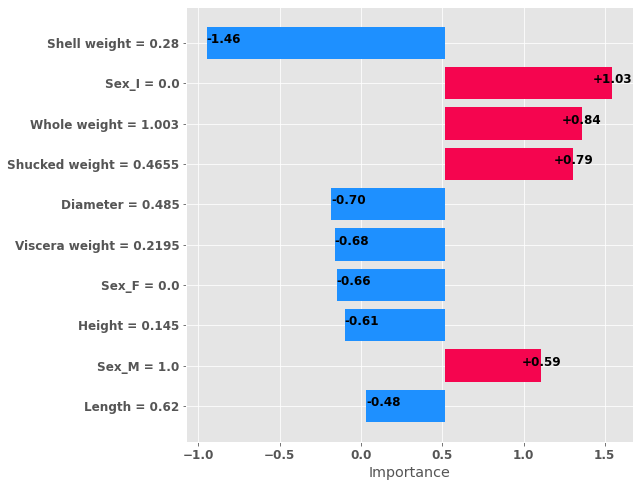

tensor([[0.3049]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [13]:
#num of features to use
top_n = 10

gnn_model.plot_bars(test[10][0].reshape(1, adj_matrix.shape[0], 1).to(device), test_data.iloc[0], top_n)
gnn_model.predict(test[10][0].reshape(1, adj_matrix.shape[0], 1).to(device))

# Interpretability Evaluation

In [14]:
importances = gnn_model.weights.cpu().detach().reshape(-1).numpy()

feature_global_importance = {}
for i, v in enumerate(importances):
    feature_global_importance[index_to_name[i]] = v

In [15]:
'''function to obtain feature scores from IGNNet model'''

def get_local_values(example, feature_global_importance, adj_matrix, index_to_name):
    array_to_use = np.array(example)    
    array = torch.FloatTensor(array_to_use).reshape(1, adj_matrix.shape[0], 1)
    local_importance = gnn_model.get_local_importance(array.to(device))[-1]

    names = []
    values = []
    for i, v in enumerate(local_importance):
        name = index_to_name[i]
        names.append(name)
        values.append(feature_global_importance[name]*v)
    return names, values

In [16]:
from sklearn.preprocessing import StandardScaler
from data_preprocess import BlackBoxWrapper

ss = StandardScaler()
ss.fit(normalized_train_data.to_numpy())

num_features = adj_matrix.shape[0]


bb = BlackBoxWrapper(gnn_model, num_features, ss, device)

def black_box(x, S):
    pred = bb(x, S)
    return pred.cpu().data.numpy()

In [17]:
'''
Evaluate a black-box model.
  x: input examples.
  S: coalitions.
'''

x = test_dataset[0][0]
x = x.reshape((1,x.shape[0])).numpy()

'''compute the feature scores on a vector of all features masked'''
S = np.zeros_like(x)
S = ss.inverse_transform(S)
_, null =  get_local_values(S, feature_global_importance, adj_matrix, index_to_name)

## Explain 500 examples and compare KernelSHAP to IGNNet after each iteration of data sampling

In [24]:
from tqdm import tqdm
import shapreg
import pickle
import os.path
from numpy.linalg import norm
from scipy.stats import spearmanr
import copy

if os.path.isfile(f'{data_name}_exp.pickle'):
    print('Loading saved explanations')

    with open(f'{data_name}_exp.pickle', 'rb') as file:
        all_instance_results_loaded = pickle.load(file)
        
    all_l2_distances = []
    all_cos_sim = []
    all_spearman_c = []

    for x, all_results in tqdm(all_instance_results_loaded):

        _, true_values = get_local_values(x, feature_global_importance, adj_matrix, index_to_name)
        
        instance_l2_dis = []
        instance_cos_sim = []
        spearman_c = []
        
        '''the Shapley values for an input x sum to the difference p(y=1 | x) - p(y=1)'''
        true_values = np.array(true_values) - null

        for i in list(all_results['iters']):

            knl_shp = all_results['values'][list(all_results['iters']).index(i)].reshape(-1)

            instance_l2_dis.append(norm(true_values - knl_shp))
            instance_cos_sim.append(np.dot(true_values, knl_shp)/(norm(true_values)*norm(knl_shp)))
            coef, p = spearmanr(true_values, knl_shp)
            spearman_c.append(coef)
            
        all_l2_distances.append(instance_l2_dis)
        all_cos_sim.append(instance_cos_sim)
        all_spearman_c.append(spearman_c)

else:
    
    all_l2_distances = []
    all_cos_sim = []
    all_instance_results = []
    all_spearman_c = []

    count = 1
    for x_, _ in tqdm(test_dataset):
        _, true_values = get_local_values(x_, feature_global_importance, adj_matrix, index_to_name)

        x = x_.reshape((1,x_.shape[0])).numpy()

        # Run KernelSHAP to convergence
        game_ = shapreg.games.PredictionGame(black_box, x)
        try:
            '''more examples are available here'''
            shap_values, all_results = shapreg.shapley.ShapleyRegression(
                game_, batch_size=16, n_samples=2000, paired_sampling=True, detect_convergence=False,
                bar=False, return_all=True)
        except:
            print('Singularity exception!')
            continue

        instance_l2_dis = []
        instance_cos_sim = []
        spearman_c = []

        true_values = np.array(true_values) - null

        for i in list(all_results['iters']):

            knl_shp = all_results['values'][list(all_results['iters']).index(i)].reshape(-1)

            instance_l2_dis.append(norm(true_values - knl_shp))
            instance_cos_sim.append(np.dot(true_values, knl_shp)/(norm(true_values)*norm(knl_shp)))
            coef, p = spearmanr(true_values, knl_shp)
            spearman_c.append(coef)
            
        all_l2_distances.append(instance_l2_dis)
        all_cos_sim.append(instance_cos_sim)
        all_spearman_c.append(spearman_c)

        all_instance_results.append((copy.deepcopy(x_), copy.deepcopy(all_results)))
        
        count += 1
        if count > 500:
            break
    print('saving explanations')

    with open(f'{data_name}_exp.pickle', 'wb') as file:
        pickle.dump(all_instance_results, file)


  0%|                                                                                          | 0/500 [00:00<?, ?it/s]

Loading saved explanations


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:33<00:00, 14.82it/s]


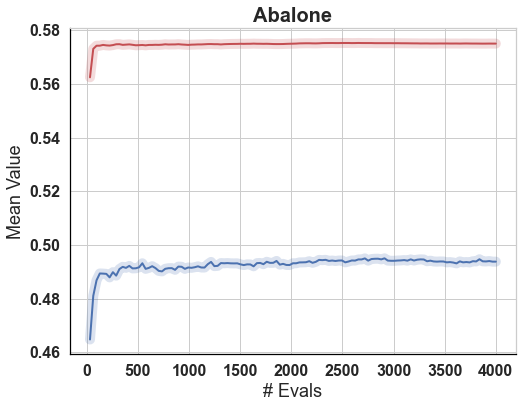

In [25]:
'''Plot the computed similarity scores'''

mean_cos_sim = np.mean(all_cos_sim, axis=0)
mean_spearman_c = np.mean(all_spearman_c, axis=0)

import matplotlib.pyplot as plt  
# Plot the line graph
import seaborn as sb
sb.set(rc={'figure.figsize':(8,6)})
sb.set_theme(style='whitegrid')

plt.plot(all_results['iters'], mean_cos_sim, "r-", linewidth=10, alpha=0.2)
plt.plot(all_results['iters'], mean_spearman_c, "b-", linewidth=10, alpha=0.2)

plt.plot(all_results['iters'], mean_cos_sim, "r-", label='Cosine Similarity', linewidth=2)
plt.plot(all_results['iters'], mean_spearman_c, "b-", label='Spearman Correlation', linewidth=2)

# Add labels and title
plt.xlabel('# Evals', fontsize=18)
plt.ylabel('Mean Value', fontsize=18)
plt.title('Abalone', fontsize=20, fontweight='bold')
#plt.legend(fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


ax = plt.gca()

ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

# Display the graph
plt.show()